# Support Vector Machine - 2 Hourly Taxi Demand Prediction

In this section we predict the 2-hourly demand of taxi trips in Chicago. 
The prediciton we perform by building a model are based on data from 2013, provided from Chicago (website: https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew).

We split the prediction into spatial units:
- Community Areas
- hexagons with low resolution
- hexagons with medium resolution
- hexagons with high resolution

For each of the units we perform a seperate prediction based on data we have aggregeated in our preparation.

For that we proceed as follows:

- Build SVM model with different kernels to find out which performs best. We do this based on Community areas.
- Hyperparameter tuning to find the best ones
- Build the model with found kernel and hyperparameters: make predictions for all spatial units
- Evaluation

<hr style="border: 1px solid #8888;">

In [1]:
# import all necessary packages
import pandas as pd
import numpy as np
import json
import datetime
import warnings
from pandas.core.common import SettingWithCopyWarning
#warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn import datasets
from scipy.stats import loguniform
# import .py file for prediction methods
import predictive as pred

<hr style="border: 1px solid #8888;">

## Preprocessing

In [2]:
# import datasets
df_2h_comar = pd.read_csv("../data/datasets/df_2h_comar.csv")
df_2h_hexlow = pd.read_csv("../data/datasets/df_2h_hexlow.csv")
df_2h_hexmed = pd.read_csv("../data/datasets/df_2h_hexmed.csv")
df_2h_hexhig = pd.read_csv("../data/datasets/df_2h_hexhig.csv")

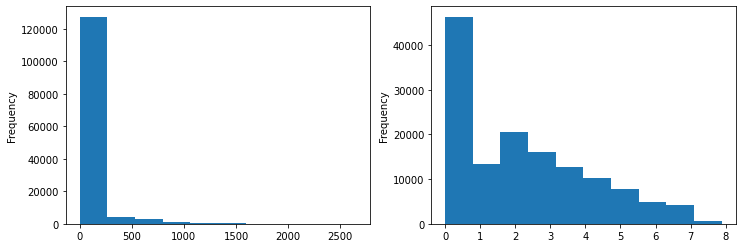

In [3]:
plt.figure(figsize=(12,4)) 

plt.subplot(121)  
df_2h_comar['numOfTaxis_area'].plot.hist()

plt.subplot(122)
df_2h_comar['numOfTaxis_area'] = np.log(df_2h_comar['numOfTaxis_area'])
df_2h_comar['numOfTaxis_area'].plot.hist()
plt.show()

In [4]:
df_2h_hexlow['numOfTaxis_area'] = np.log(df_2h_hexlow['numOfTaxis_area'])
df_2h_hexmed['numOfTaxis_area'] = np.log(df_2h_hexmed['numOfTaxis_area'])
df_2h_hexhig['numOfTaxis_area'] = np.log(df_2h_hexhig['numOfTaxis_area'])

In [5]:
df_2h_comar.drop(columns = ['date_start'],inplace = True)
df_2h_hexlow.drop(columns = ['date_start'],inplace = True)
df_2h_hexmed.drop(columns = ['date_start'],inplace = True)
df_2h_hexhig.drop(columns = ['date_start'],inplace = True)

In [6]:
df_2h_comar = pred.dayandseas_to_int(df_2h_comar)
df_2h_hexlow = pred.dayandseas_to_int(df_2h_hexlow)
df_2h_hexmed = pred.dayandseas_to_int(df_2h_hexmed)
df_2h_hexhig = pred.dayandseas_to_int(df_2h_hexhig)

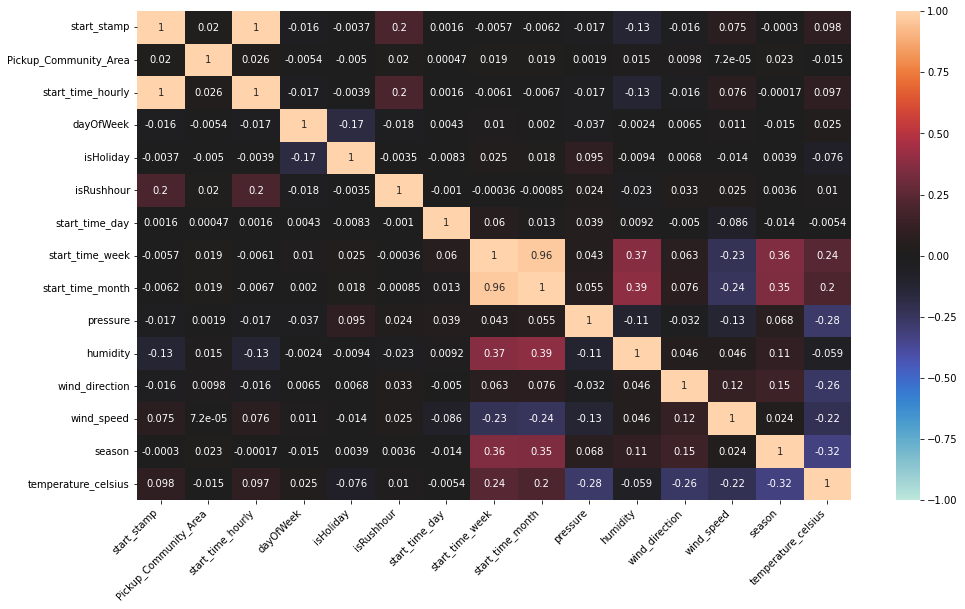

In [7]:
# correlation matrix of df_h_comar

import seaborn as sns
corr = df_2h_comar.drop(columns = ['numOfTaxis_area']).corr()
plt.figure(figsize = (16,9))
ax = sns.heatmap(corr, vmin = -1, vmax= 1, center = 0, annot=True)

ax.set_xticklabels(ax.get_xticklabels(),
                  rotation = 45,
                  horizontalalignment = 'right')

ax.set_yticklabels(ax.get_yticklabels(),
                   rotation =0,
                   horizontalalignment = 'right')

plt.show()

We have a very high correlation between `start_time_month` and `start_time_week`, which leads to dropping `start_time_month`. In addition to that we have a perfect correlation between `start_time_hourly` and `start_stamp` (because we look at 2-hourly data and `start_stamp` represents the start of the interval). So we drop `start_time_hourly`, because we are interested in the 2-hourly interval (which start is represented by `start_stamp`):

In [8]:
df_2h_comar.drop(columns = ['start_time_month'],inplace = True)

In [9]:
df_2h_comar.drop(columns = ['start_time_hourly'],inplace = True)

Doing the same for the dataframes of:

- hexagons with low resolution
- hexagons with medium resolution
- hexagons with high resolution

In [10]:
df_2h_hexlow.drop(columns = ['start_time_hourly','start_time_month'],inplace = True)
df_2h_hexmed.drop(columns = ['start_time_hourly','start_time_month'],inplace = True)
df_2h_hexhig.drop(columns = ['start_time_hourly','start_time_month'],inplace = True)

<hr style="border: 1px solid #8888;">

## 2 Hourly Demand - Community Area

In [11]:
x_train_val, y_train_val, x_train, y_train, x_val, y_val, x_test, y_test = pred.train_val_test(df_2h_comar,
                                                                                        testsize=0.3,
                                                                                        valsize=0.2)

In [12]:
categoric, numeric = pred.cat_and_num('Pickup_Community_Area')

### Building the model: Checking for the best kernel

#### SVR KERNEL: LINEAR

In [13]:
svr_lin = SVR(kernel = 'linear',verbose = 10,cache_size=15000, max_iter=50000)

In [14]:
pipeline = pred.pipeline_fit_predict(svr_lin, categoric, numeric, x_train, y_train, x_val, y_val,
                               df_2h_comar, 'numOfTaxis_area',if_log = True)

[LibSVM].................................................WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50000
obj = -26534.020512, rho = -0.885370
nSV = 37939, nBSV = 29166


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MODEL SCORES:
MAE:  31.9225
MSE:  10059.7790
RMSE:  100.2984
MAPE:  70.2174 %
Rough Accuracy Approximation: 74.3 %
R2:  85.7809 %
Max Residual Error:  1735.3965


#### SVR KERNEL: POLYNOMIAL WITH DEGREE 2

In [15]:
svr_poly2 = SVR(kernel = 'poly',degree = 2, verbose = 10,cache_size=15000, max_iter=50000)

In [16]:
pipeline = pred.pipeline_fit_predict(svr_poly2, categoric, numeric, x_train, y_train, x_val, y_val,
                                df_2h_comar, 'numOfTaxis_area',if_log = True)

[LibSVM].................................................WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50000
obj = -22671.080751, rho = -1.114934
nSV = 52073, nBSV = 45854


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MODEL SCORES:
MAE:  14.2078
MSE:  2296.6588
RMSE:  47.9235
MAPE:  40.1615 %
Rough Accuracy Approximation: 83.98 %
R2:  94.1729 %
Max Residual Error:  908.4738


#### SVR KERNEL: POLYNOMIAL WITH DEGREE 3

In [17]:
svr_poly3 = SVR(kernel = 'poly',verbose = 10,cache_size=15000, max_iter=50000)

In [18]:
pipeline = pred.pipeline_fit_predict(svr_poly3, categoric, numeric, x_train, y_train, x_val, y_val,
                                df_2h_comar, 'numOfTaxis_area',if_log = True)

[LibSVM].................................................WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50000
obj = -24925.725789, rho = -1.360172
nSV = 53363, nBSV = 40549


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MODEL SCORES:
MAE:  17.9677
MSE:  4096.7381
RMSE:  64.0058
MAPE:  43.6338 %
Rough Accuracy Approximation: 82.75 %
R2:  93.5324 %
Max Residual Error:  1300.6309


#### SVR KERNEL: RBF

In [19]:
svr_rbf = SVR(kernel = 'rbf',verbose = 10,cache_size=15000, max_iter=50000)

In [20]:
pipeline =pred.pipeline_fit_predict(svr_rbf, categoric, numeric, x_train, y_train, x_val, y_val,
                                df_2h_comar, 'numOfTaxis_area',if_log = True)

[LibSVM].................................................WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50000
obj = -25650.732212, rho = -1.481372
nSV = 54969, nBSV = 45109


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MODEL SCORES:
MAE:  19.2075
MSE:  4379.9197
RMSE:  66.1810
MAPE:  45.5852 %
Rough Accuracy Approximation: 82.19 %
R2:  93.0574 %
Max Residual Error:  1175.4184


<hr style="border: 0.5px solid #8888;">

### Hyperparameter Tuning for the best model

The model which performs best regarding all metrices we looked at, was the support vector machine with the polynomial kernel with degree 2, while the perfomance of the linear model is by far the worst. We can not observe a big difference in the performances of rbf kernel or polynomial kernel with degree 3. We monitor nervetheless that the scores are slightly better for polynomial degree 3 kernel (except from maximal residual error).

So in the next section we are going to perform a hyperparameter tuning on this model. For this we are using the hyperparameters:
- `C`: regularization parameter
- `epsilon`: margin of tolerance where no penalty is given to errors
- `coef0`: an independent term in kernel function ('intercept', constant offset determines position of hyperplane)
- `gamma`: kernel coefficient (determines shape of decision boundary/influence of single training example)

#### Sampling data for tuning:

In [21]:
# creating the ranges for model parameter to use in find_best_hyperparameters

model_para = {'model__C':loguniform(1e-1, 1e2),        
                'model__epsilon':loguniform(1e-1, 1e2),  
                'model__coef0':loguniform(1e0, 1e6),    
                'model__gamma':loguniform(1e-2, 1e1)   
                }              

In [22]:
svr_poly2 = SVR(kernel = 'poly',degree = 2,cache_size=15000, max_iter=50000)

In [23]:
pipeline = pred.pipeline_for_prediction(categoric, numeric, svr_poly2)

In [24]:
pred.find_best_hyperparameters(pipeline, x_val, y_val, model_para, score = 'neg_mean_absolute_error', verbose=10)

Running grid search for the model based on neg_mean_absolute_error
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5; 1/100] START model__C=1.3292918943162166, model__coef0=506157.68887523044, model__epsilon=15.702970884055382, model__gamma=0.6251373574521749
[CV 1/5; 1/100] END model__C=1.3292918943162166, model__coef0=506157.68887523044, model__epsilon=15.702970884055382, model__gamma=0.6251373574521749;, score=-2.162 total time=   0.0s
[CV 2/5; 1/100] START model__C=1.3292918943162166, model__coef0=506157.68887523044, model__epsilon=15.702970884055382, model__gamma=0.6251373574521749
[CV 2/5; 1/100] END model__C=1.3292918943162166, model__coef0=506157.68887523044, model__epsilon=15.702970884055382, model__gamma=0.6251373574521749;, score=-2.281 total time=   0.0s
[CV 3/5; 1/100] START model__C=1.3292918943162166, model__coef0=506157.68887523044, model__epsilon=15.702970884055382, model__gamma=0.6251373574521749
[CV 3/5; 1/100] END model__C=1.3292918943162166, mo

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 2/100] END model__C=0.2938027938703535, model__coef0=8.629132190071854, model__epsilon=0.14936568554617632, model__gamma=3.9676050770529883;, score=-0.540 total time=   4.2s
[CV 2/5; 2/100] START model__C=0.2938027938703535, model__coef0=8.629132190071854, model__epsilon=0.14936568554617632, model__gamma=3.9676050770529883


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 2/100] END model__C=0.2938027938703535, model__coef0=8.629132190071854, model__epsilon=0.14936568554617632, model__gamma=3.9676050770529883;, score=-0.552 total time=  11.2s
[CV 3/5; 2/100] START model__C=0.2938027938703535, model__coef0=8.629132190071854, model__epsilon=0.14936568554617632, model__gamma=3.9676050770529883


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 2/100] END model__C=0.2938027938703535, model__coef0=8.629132190071854, model__epsilon=0.14936568554617632, model__gamma=3.9676050770529883;, score=-0.537 total time=  18.1s
[CV 4/5; 2/100] START model__C=0.2938027938703535, model__coef0=8.629132190071854, model__epsilon=0.14936568554617632, model__gamma=3.9676050770529883


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 2/100] END model__C=0.2938027938703535, model__coef0=8.629132190071854, model__epsilon=0.14936568554617632, model__gamma=3.9676050770529883;, score=-0.534 total time=  25.9s
[CV 5/5; 2/100] START model__C=0.2938027938703535, model__coef0=8.629132190071854, model__epsilon=0.14936568554617632, model__gamma=3.9676050770529883


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 2/100] END model__C=0.2938027938703535, model__coef0=8.629132190071854, model__epsilon=0.14936568554617632, model__gamma=3.9676050770529883;, score=-0.539 total time=  33.9s
[CV 1/5; 3/100] START model__C=6.358358856676251, model__coef0=17718.847354806814, model__epsilon=0.115279871282324, model__gamma=8.123245085588687


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 3/100] END model__C=6.358358856676251, model__coef0=17718.847354806814, model__epsilon=0.115279871282324, model__gamma=8.123245085588687;, score=-0.771 total time=   5.0s
[CV 2/5; 3/100] START model__C=6.358358856676251, model__coef0=17718.847354806814, model__epsilon=0.115279871282324, model__gamma=8.123245085588687


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 3/100] END model__C=6.358358856676251, model__coef0=17718.847354806814, model__epsilon=0.115279871282324, model__gamma=8.123245085588687;, score=-0.793 total time=  10.1s
[CV 3/5; 3/100] START model__C=6.358358856676251, model__coef0=17718.847354806814, model__epsilon=0.115279871282324, model__gamma=8.123245085588687


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 3/100] END model__C=6.358358856676251, model__coef0=17718.847354806814, model__epsilon=0.115279871282324, model__gamma=8.123245085588687;, score=-0.767 total time=  15.8s
[CV 4/5; 3/100] START model__C=6.358358856676251, model__coef0=17718.847354806814, model__epsilon=0.115279871282324, model__gamma=8.123245085588687


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 3/100] END model__C=6.358358856676251, model__coef0=17718.847354806814, model__epsilon=0.115279871282324, model__gamma=8.123245085588687;, score=-0.709 total time=  21.6s
[CV 5/5; 3/100] START model__C=6.358358856676251, model__coef0=17718.847354806814, model__epsilon=0.115279871282324, model__gamma=8.123245085588687


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 3/100] END model__C=6.358358856676251, model__coef0=17718.847354806814, model__epsilon=0.115279871282324, model__gamma=8.123245085588687;, score=-0.795 total time=  28.1s
[CV 1/5; 4/100] START model__C=31.428808908401084, model__coef0=18.794668241638455, model__epsilon=0.3511356313970407, model__gamma=0.03549878832196503


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 4/100] END model__C=31.428808908401084, model__coef0=18.794668241638455, model__epsilon=0.3511356313970407, model__gamma=0.03549878832196503;, score=-0.534 total time=   3.9s
[CV 2/5; 4/100] START model__C=31.428808908401084, model__coef0=18.794668241638455, model__epsilon=0.3511356313970407, model__gamma=0.03549878832196503


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 4/100] END model__C=31.428808908401084, model__coef0=18.794668241638455, model__epsilon=0.3511356313970407, model__gamma=0.03549878832196503;, score=-0.536 total time=   8.8s
[CV 3/5; 4/100] START model__C=31.428808908401084, model__coef0=18.794668241638455, model__epsilon=0.3511356313970407, model__gamma=0.03549878832196503


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 4/100] END model__C=31.428808908401084, model__coef0=18.794668241638455, model__epsilon=0.3511356313970407, model__gamma=0.03549878832196503;, score=-0.506 total time=  14.2s
[CV 4/5; 4/100] START model__C=31.428808908401084, model__coef0=18.794668241638455, model__epsilon=0.3511356313970407, model__gamma=0.03549878832196503


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 4/100] END model__C=31.428808908401084, model__coef0=18.794668241638455, model__epsilon=0.3511356313970407, model__gamma=0.03549878832196503;, score=-0.525 total time=  20.1s
[CV 5/5; 4/100] START model__C=31.428808908401084, model__coef0=18.794668241638455, model__epsilon=0.3511356313970407, model__gamma=0.03549878832196503


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 4/100] END model__C=31.428808908401084, model__coef0=18.794668241638455, model__epsilon=0.3511356313970407, model__gamma=0.03549878832196503;, score=-0.636 total time=  26.1s
[CV 1/5; 5/100] START model__C=0.8179499475211672, model__coef0=1407.7923139972395, model__epsilon=1.976218934028007, model__gamma=0.07476312062252301
[CV 1/5; 5/100] END model__C=0.8179499475211672, model__coef0=1407.7923139972395, model__epsilon=1.976218934028007, model__gamma=0.07476312062252301;, score=-0.919 total time=   0.2s
[CV 2/5; 5/100] START model__C=0.8179499475211672, model__coef0=1407.7923139972395, model__epsilon=1.976218934028007, model__gamma=0.07476312062252301


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 5/100] END model__C=0.8179499475211672, model__coef0=1407.7923139972395, model__epsilon=1.976218934028007, model__gamma=0.07476312062252301;, score=-0.809 total time=   0.4s
[CV 3/5; 5/100] START model__C=0.8179499475211672, model__coef0=1407.7923139972395, model__epsilon=1.976218934028007, model__gamma=0.07476312062252301


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 5/100] END model__C=0.8179499475211672, model__coef0=1407.7923139972395, model__epsilon=1.976218934028007, model__gamma=0.07476312062252301;, score=-0.753 total time=   0.6s
[CV 4/5; 5/100] START model__C=0.8179499475211672, model__coef0=1407.7923139972395, model__epsilon=1.976218934028007, model__gamma=0.07476312062252301


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 5/100] END model__C=0.8179499475211672, model__coef0=1407.7923139972395, model__epsilon=1.976218934028007, model__gamma=0.07476312062252301;, score=-0.723 total time=   0.9s
[CV 5/5; 5/100] START model__C=0.8179499475211672, model__coef0=1407.7923139972395, model__epsilon=1.976218934028007, model__gamma=0.07476312062252301


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 5/100] END model__C=0.8179499475211672, model__coef0=1407.7923139972395, model__epsilon=1.976218934028007, model__gamma=0.07476312062252301;, score=-0.732 total time=   1.2s
[CV 1/5; 6/100] START model__C=6.847920095574778, model__coef0=6.870101665590024, model__epsilon=0.7523742884534856, model__gamma=0.1256277350380703


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 6/100] END model__C=6.847920095574778, model__coef0=6.870101665590024, model__epsilon=0.7523742884534856, model__gamma=0.1256277350380703;, score=-0.540 total time=   1.4s
[CV 2/5; 6/100] START model__C=6.847920095574778, model__coef0=6.870101665590024, model__epsilon=0.7523742884534856, model__gamma=0.1256277350380703


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 6/100] END model__C=6.847920095574778, model__coef0=6.870101665590024, model__epsilon=0.7523742884534856, model__gamma=0.1256277350380703;, score=-0.500 total time=   3.5s
[CV 3/5; 6/100] START model__C=6.847920095574778, model__coef0=6.870101665590024, model__epsilon=0.7523742884534856, model__gamma=0.1256277350380703


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 6/100] END model__C=6.847920095574778, model__coef0=6.870101665590024, model__epsilon=0.7523742884534856, model__gamma=0.1256277350380703;, score=-0.477 total time=   6.1s
[CV 4/5; 6/100] START model__C=6.847920095574778, model__coef0=6.870101665590024, model__epsilon=0.7523742884534856, model__gamma=0.1256277350380703


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 6/100] END model__C=6.847920095574778, model__coef0=6.870101665590024, model__epsilon=0.7523742884534856, model__gamma=0.1256277350380703;, score=-0.468 total time=   9.7s
[CV 5/5; 6/100] START model__C=6.847920095574778, model__coef0=6.870101665590024, model__epsilon=0.7523742884534856, model__gamma=0.1256277350380703


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 6/100] END model__C=6.847920095574778, model__coef0=6.870101665590024, model__epsilon=0.7523742884534856, model__gamma=0.1256277350380703;, score=-0.460 total time=  13.7s
[CV 1/5; 7/100] START model__C=2.334586407601624, model__coef0=51410.96648805743, model__epsilon=0.3972110727381912, model__gamma=0.34890188454913873


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 7/100] END model__C=2.334586407601624, model__coef0=51410.96648805743, model__epsilon=0.3972110727381912, model__gamma=0.34890188454913873;, score=-8729.693 total time=   5.4s
[CV 2/5; 7/100] START model__C=2.334586407601624, model__coef0=51410.96648805743, model__epsilon=0.3972110727381912, model__gamma=0.34890188454913873


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 7/100] END model__C=2.334586407601624, model__coef0=51410.96648805743, model__epsilon=0.3972110727381912, model__gamma=0.34890188454913873;, score=-11458.372 total time=  12.0s
[CV 3/5; 7/100] START model__C=2.334586407601624, model__coef0=51410.96648805743, model__epsilon=0.3972110727381912, model__gamma=0.34890188454913873


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 7/100] END model__C=2.334586407601624, model__coef0=51410.96648805743, model__epsilon=0.3972110727381912, model__gamma=0.34890188454913873;, score=-19004.512 total time=  19.8s
[CV 4/5; 7/100] START model__C=2.334586407601624, model__coef0=51410.96648805743, model__epsilon=0.3972110727381912, model__gamma=0.34890188454913873


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 7/100] END model__C=2.334586407601624, model__coef0=51410.96648805743, model__epsilon=0.3972110727381912, model__gamma=0.34890188454913873;, score=-20953.839 total time=  30.0s
[CV 5/5; 7/100] START model__C=2.334586407601624, model__coef0=51410.96648805743, model__epsilon=0.3972110727381912, model__gamma=0.34890188454913873


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 7/100] END model__C=2.334586407601624, model__coef0=51410.96648805743, model__epsilon=0.3972110727381912, model__gamma=0.34890188454913873;, score=-27116.015 total time=  40.0s
[CV 1/5; 8/100] START model__C=5.9874749104613985, model__coef0=1.8997763474111278, model__epsilon=6.647135865318027, model__gamma=0.03247673570627449
[CV 1/5; 8/100] END model__C=5.9874749104613985, model__coef0=1.8997763474111278, model__epsilon=6.647135865318027, model__gamma=0.03247673570627449;, score=-2.162 total time=   0.0s
[CV 2/5; 8/100] START model__C=5.9874749104613985, model__coef0=1.8997763474111278, model__epsilon=6.647135865318027, model__gamma=0.03247673570627449
[CV 2/5; 8/100] END model__C=5.9874749104613985, model__coef0=1.8997763474111278, model__epsilon=6.647135865318027, model__gamma=0.03247673570627449;, score=-2.281 total time=   0.0s
[CV 3/5; 8/100] START model__C=5.9874749104613985, model__coef0=1.8997763474111278, model__epsilon=6.647135865318027, model__gamma=0.0324767357062

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 11/100] END model__C=0.2323350351539011, model__coef0=935.5380606452178, model__epsilon=0.12681352169084595, model__gamma=5.345166110646819;, score=-0.514 total time=   5.1s
[CV 2/5; 11/100] START model__C=0.2323350351539011, model__coef0=935.5380606452178, model__epsilon=0.12681352169084595, model__gamma=5.345166110646819


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 11/100] END model__C=0.2323350351539011, model__coef0=935.5380606452178, model__epsilon=0.12681352169084595, model__gamma=5.345166110646819;, score=-0.526 total time=  10.8s
[CV 3/5; 11/100] START model__C=0.2323350351539011, model__coef0=935.5380606452178, model__epsilon=0.12681352169084595, model__gamma=5.345166110646819


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 11/100] END model__C=0.2323350351539011, model__coef0=935.5380606452178, model__epsilon=0.12681352169084595, model__gamma=5.345166110646819;, score=-0.585 total time=  17.1s
[CV 4/5; 11/100] START model__C=0.2323350351539011, model__coef0=935.5380606452178, model__epsilon=0.12681352169084595, model__gamma=5.345166110646819


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 11/100] END model__C=0.2323350351539011, model__coef0=935.5380606452178, model__epsilon=0.12681352169084595, model__gamma=5.345166110646819;, score=-0.531 total time=  24.4s
[CV 5/5; 11/100] START model__C=0.2323350351539011, model__coef0=935.5380606452178, model__epsilon=0.12681352169084595, model__gamma=5.345166110646819


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 11/100] END model__C=0.2323350351539011, model__coef0=935.5380606452178, model__epsilon=0.12681352169084595, model__gamma=5.345166110646819;, score=-0.562 total time=  31.5s
[CV 1/5; 12/100] START model__C=0.5975027999960293, model__coef0=9443.515687962672, model__epsilon=0.8612579192594884, model__gamma=0.3632486956676606


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 12/100] END model__C=0.5975027999960293, model__coef0=9443.515687962672, model__epsilon=0.8612579192594884, model__gamma=0.3632486956676606;, score=-2.233 total time=   3.1s
[CV 2/5; 12/100] START model__C=0.5975027999960293, model__coef0=9443.515687962672, model__epsilon=0.8612579192594884, model__gamma=0.3632486956676606


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 12/100] END model__C=0.5975027999960293, model__coef0=9443.515687962672, model__epsilon=0.8612579192594884, model__gamma=0.3632486956676606;, score=-7.365 total time=   8.2s
[CV 3/5; 12/100] START model__C=0.5975027999960293, model__coef0=9443.515687962672, model__epsilon=0.8612579192594884, model__gamma=0.3632486956676606


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 12/100] END model__C=0.5975027999960293, model__coef0=9443.515687962672, model__epsilon=0.8612579192594884, model__gamma=0.3632486956676606;, score=-13.059 total time=  14.6s
[CV 4/5; 12/100] START model__C=0.5975027999960293, model__coef0=9443.515687962672, model__epsilon=0.8612579192594884, model__gamma=0.3632486956676606


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 12/100] END model__C=0.5975027999960293, model__coef0=9443.515687962672, model__epsilon=0.8612579192594884, model__gamma=0.3632486956676606;, score=-17.095 total time=  19.2s
[CV 5/5; 12/100] START model__C=0.5975027999960293, model__coef0=9443.515687962672, model__epsilon=0.8612579192594884, model__gamma=0.3632486956676606


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 12/100] END model__C=0.5975027999960293, model__coef0=9443.515687962672, model__epsilon=0.8612579192594884, model__gamma=0.3632486956676606;, score=-16.007 total time=  24.6s
[CV 1/5; 13/100] START model__C=4.366473592979633, model__coef0=12.856617791467924, model__epsilon=81.05016126411583, model__gamma=2.1154290797261215
[CV 1/5; 13/100] END model__C=4.366473592979633, model__coef0=12.856617791467924, model__epsilon=81.05016126411583, model__gamma=2.1154290797261215;, score=-2.162 total time=   0.0s
[CV 2/5; 13/100] START model__C=4.366473592979633, model__coef0=12.856617791467924, model__epsilon=81.05016126411583, model__gamma=2.1154290797261215
[CV 2/5; 13/100] END model__C=4.366473592979633, model__coef0=12.856617791467924, model__epsilon=81.05016126411583, model__gamma=2.1154290797261215;, score=-2.281 total time=   0.0s
[CV 3/5; 13/100] START model__C=4.366473592979633, model__coef0=12.856617791467924, model__epsilon=81.05016126411583, model__gamma=2.1154290797261215
[C

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 15/100] END model__C=0.18427970406864538, model__coef0=14.993298055091547, model__epsilon=0.13667272915456222, model__gamma=0.09462175356461491;, score=-0.498 total time=   2.6s
[CV 2/5; 15/100] START model__C=0.18427970406864538, model__coef0=14.993298055091547, model__epsilon=0.13667272915456222, model__gamma=0.09462175356461491


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 15/100] END model__C=0.18427970406864538, model__coef0=14.993298055091547, model__epsilon=0.13667272915456222, model__gamma=0.09462175356461491;, score=-0.485 total time=   7.6s
[CV 3/5; 15/100] START model__C=0.18427970406864538, model__coef0=14.993298055091547, model__epsilon=0.13667272915456222, model__gamma=0.09462175356461491


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 15/100] END model__C=0.18427970406864538, model__coef0=14.993298055091547, model__epsilon=0.13667272915456222, model__gamma=0.09462175356461491;, score=-0.455 total time=  15.2s
[CV 4/5; 15/100] START model__C=0.18427970406864538, model__coef0=14.993298055091547, model__epsilon=0.13667272915456222, model__gamma=0.09462175356461491


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 15/100] END model__C=0.18427970406864538, model__coef0=14.993298055091547, model__epsilon=0.13667272915456222, model__gamma=0.09462175356461491;, score=-0.447 total time=  25.2s
[CV 5/5; 15/100] START model__C=0.18427970406864538, model__coef0=14.993298055091547, model__epsilon=0.13667272915456222, model__gamma=0.09462175356461491


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 15/100] END model__C=0.18427970406864538, model__coef0=14.993298055091547, model__epsilon=0.13667272915456222, model__gamma=0.09462175356461491;, score=-0.435 total time=  37.4s
[CV 1/5; 16/100] START model__C=1.4656553886225332, model__coef0=42.47116662617142, model__epsilon=30.634622106220824, model__gamma=0.11756010900231852
[CV 1/5; 16/100] END model__C=1.4656553886225332, model__coef0=42.47116662617142, model__epsilon=30.634622106220824, model__gamma=0.11756010900231852;, score=-2.162 total time=   0.0s
[CV 2/5; 16/100] START model__C=1.4656553886225332, model__coef0=42.47116662617142, model__epsilon=30.634622106220824, model__gamma=0.11756010900231852
[CV 2/5; 16/100] END model__C=1.4656553886225332, model__coef0=42.47116662617142, model__epsilon=30.634622106220824, model__gamma=0.11756010900231852;, score=-2.281 total time=   0.0s
[CV 3/5; 16/100] START model__C=1.4656553886225332, model__coef0=42.47116662617142, model__epsilon=30.634622106220824, model__gamma=0.1175601

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 17/100] END model__C=0.6963114377829286, model__coef0=1803.7506431281838, model__epsilon=0.2647114182821816, model__gamma=2.5502980701628926;, score=-0.560 total time=   4.5s
[CV 2/5; 17/100] START model__C=0.6963114377829286, model__coef0=1803.7506431281838, model__epsilon=0.2647114182821816, model__gamma=2.5502980701628926


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 17/100] END model__C=0.6963114377829286, model__coef0=1803.7506431281838, model__epsilon=0.2647114182821816, model__gamma=2.5502980701628926;, score=-0.693 total time=   9.6s
[CV 3/5; 17/100] START model__C=0.6963114377829286, model__coef0=1803.7506431281838, model__epsilon=0.2647114182821816, model__gamma=2.5502980701628926


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 17/100] END model__C=0.6963114377829286, model__coef0=1803.7506431281838, model__epsilon=0.2647114182821816, model__gamma=2.5502980701628926;, score=-0.682 total time=  15.2s
[CV 4/5; 17/100] START model__C=0.6963114377829286, model__coef0=1803.7506431281838, model__epsilon=0.2647114182821816, model__gamma=2.5502980701628926


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 17/100] END model__C=0.6963114377829286, model__coef0=1803.7506431281838, model__epsilon=0.2647114182821816, model__gamma=2.5502980701628926;, score=-0.621 total time=  21.2s
[CV 5/5; 17/100] START model__C=0.6963114377829286, model__coef0=1803.7506431281838, model__epsilon=0.2647114182821816, model__gamma=2.5502980701628926


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 17/100] END model__C=0.6963114377829286, model__coef0=1803.7506431281838, model__epsilon=0.2647114182821816, model__gamma=2.5502980701628926;, score=-0.673 total time=  27.7s
[CV 1/5; 18/100] START model__C=0.16736010167825777, model__coef0=834298.8013047343, model__epsilon=20.73644517790503, model__gamma=0.03945908811100001
[CV 1/5; 18/100] END model__C=0.16736010167825777, model__coef0=834298.8013047343, model__epsilon=20.73644517790503, model__gamma=0.03945908811100001;, score=-2.162 total time=   0.0s
[CV 2/5; 18/100] START model__C=0.16736010167825777, model__coef0=834298.8013047343, model__epsilon=20.73644517790503, model__gamma=0.03945908811100001
[CV 2/5; 18/100] END model__C=0.16736010167825777, model__coef0=834298.8013047343, model__epsilon=20.73644517790503, model__gamma=0.03945908811100001;, score=-2.281 total time=   0.0s
[CV 3/5; 18/100] START model__C=0.16736010167825777, model__coef0=834298.8013047343, model__epsilon=20.73644517790503, model__gamma=0.0394590881

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 20/100] END model__C=20.59733535743719, model__coef0=2.7814285643757533, model__epsilon=1.1895896737553546, model__gamma=0.022264204303769682;, score=-0.588 total time=   2.5s
[CV 4/5; 20/100] START model__C=20.59733535743719, model__coef0=2.7814285643757533, model__epsilon=1.1895896737553546, model__gamma=0.022264204303769682


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 20/100] END model__C=20.59733535743719, model__coef0=2.7814285643757533, model__epsilon=1.1895896737553546, model__gamma=0.022264204303769682;, score=-0.571 total time=   3.5s
[CV 5/5; 20/100] START model__C=20.59733535743719, model__coef0=2.7814285643757533, model__epsilon=1.1895896737553546, model__gamma=0.022264204303769682


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 20/100] END model__C=20.59733535743719, model__coef0=2.7814285643757533, model__epsilon=1.1895896737553546, model__gamma=0.022264204303769682;, score=-0.584 total time=   4.6s
[CV 1/5; 21/100] START model__C=38.8427775470314, model__coef0=5492.736444508447, model__epsilon=0.9833181933644887, model__gamma=0.015512259126484752


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 21/100] END model__C=38.8427775470314, model__coef0=5492.736444508447, model__epsilon=0.9833181933644887, model__gamma=0.015512259126484752;, score=-1012.729 total time=   3.8s
[CV 2/5; 21/100] START model__C=38.8427775470314, model__coef0=5492.736444508447, model__epsilon=0.9833181933644887, model__gamma=0.015512259126484752


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 21/100] END model__C=38.8427775470314, model__coef0=5492.736444508447, model__epsilon=0.9833181933644887, model__gamma=0.015512259126484752;, score=-1304.393 total time=  11.5s
[CV 3/5; 21/100] START model__C=38.8427775470314, model__coef0=5492.736444508447, model__epsilon=0.9833181933644887, model__gamma=0.015512259126484752


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 21/100] END model__C=38.8427775470314, model__coef0=5492.736444508447, model__epsilon=0.9833181933644887, model__gamma=0.015512259126484752;, score=-1935.302 total time=  21.2s
[CV 4/5; 21/100] START model__C=38.8427775470314, model__coef0=5492.736444508447, model__epsilon=0.9833181933644887, model__gamma=0.015512259126484752


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 21/100] END model__C=38.8427775470314, model__coef0=5492.736444508447, model__epsilon=0.9833181933644887, model__gamma=0.015512259126484752;, score=-2050.163 total time=  32.7s
[CV 5/5; 21/100] START model__C=38.8427775470314, model__coef0=5492.736444508447, model__epsilon=0.9833181933644887, model__gamma=0.015512259126484752


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 21/100] END model__C=38.8427775470314, model__coef0=5492.736444508447, model__epsilon=0.9833181933644887, model__gamma=0.015512259126484752;, score=-3137.536 total time=  44.3s
[CV 1/5; 22/100] START model__C=0.8569331925053982, model__coef0=89.3511059033186, model__epsilon=15.446089075047073, model__gamma=0.817847657433954
[CV 1/5; 22/100] END model__C=0.8569331925053982, model__coef0=89.3511059033186, model__epsilon=15.446089075047073, model__gamma=0.817847657433954;, score=-2.162 total time=   0.0s
[CV 2/5; 22/100] START model__C=0.8569331925053982, model__coef0=89.3511059033186, model__epsilon=15.446089075047073, model__gamma=0.817847657433954
[CV 2/5; 22/100] END model__C=0.8569331925053982, model__coef0=89.3511059033186, model__epsilon=15.446089075047073, model__gamma=0.817847657433954;, score=-2.281 total time=   0.0s
[CV 3/5; 22/100] START model__C=0.8569331925053982, model__coef0=89.3511059033186, model__epsilon=15.446089075047073, model__gamma=0.817847657433954
[CV 3

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 23/100] END model__C=45.88156549160973, model__coef0=681.2233896860295, model__epsilon=0.22844556850020528, model__gamma=1.3795402040204179;, score=-0.536 total time=   4.8s
[CV 2/5; 23/100] START model__C=45.88156549160973, model__coef0=681.2233896860295, model__epsilon=0.22844556850020528, model__gamma=1.3795402040204179


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 23/100] END model__C=45.88156549160973, model__coef0=681.2233896860295, model__epsilon=0.22844556850020528, model__gamma=1.3795402040204179;, score=-0.569 total time=  10.1s
[CV 3/5; 23/100] START model__C=45.88156549160973, model__coef0=681.2233896860295, model__epsilon=0.22844556850020528, model__gamma=1.3795402040204179


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 23/100] END model__C=45.88156549160973, model__coef0=681.2233896860295, model__epsilon=0.22844556850020528, model__gamma=1.3795402040204179;, score=-0.597 total time=  15.7s
[CV 4/5; 23/100] START model__C=45.88156549160973, model__coef0=681.2233896860295, model__epsilon=0.22844556850020528, model__gamma=1.3795402040204179


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 23/100] END model__C=45.88156549160973, model__coef0=681.2233896860295, model__epsilon=0.22844556850020528, model__gamma=1.3795402040204179;, score=-0.613 total time=  22.2s
[CV 5/5; 23/100] START model__C=45.88156549160973, model__coef0=681.2233896860295, model__epsilon=0.22844556850020528, model__gamma=1.3795402040204179


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 23/100] END model__C=45.88156549160973, model__coef0=681.2233896860295, model__epsilon=0.22844556850020528, model__gamma=1.3795402040204179;, score=-0.606 total time=  28.7s
[CV 1/5; 24/100] START model__C=19.158219548093165, model__coef0=2331.649063896062, model__epsilon=20.55424552015074, model__gamma=0.30296104428212484
[CV 1/5; 24/100] END model__C=19.158219548093165, model__coef0=2331.649063896062, model__epsilon=20.55424552015074, model__gamma=0.30296104428212484;, score=-2.162 total time=   0.0s
[CV 2/5; 24/100] START model__C=19.158219548093165, model__coef0=2331.649063896062, model__epsilon=20.55424552015074, model__gamma=0.30296104428212484
[CV 2/5; 24/100] END model__C=19.158219548093165, model__coef0=2331.649063896062, model__epsilon=20.55424552015074, model__gamma=0.30296104428212484;, score=-2.281 total time=   0.0s
[CV 3/5; 24/100] START model__C=19.158219548093165, model__coef0=2331.649063896062, model__epsilon=20.55424552015074, model__gamma=0.3029610442821248

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 25/100] END model__C=3.699972431463808, model__coef0=367.4904945305323, model__epsilon=0.11919481947918735, model__gamma=0.021070472806578238;, score=-0.762 total time=   4.9s
[CV 2/5; 25/100] START model__C=3.699972431463808, model__coef0=367.4904945305323, model__epsilon=0.11919481947918735, model__gamma=0.021070472806578238


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 25/100] END model__C=3.699972431463808, model__coef0=367.4904945305323, model__epsilon=0.11919481947918735, model__gamma=0.021070472806578238;, score=-0.698 total time=   9.9s
[CV 3/5; 25/100] START model__C=3.699972431463808, model__coef0=367.4904945305323, model__epsilon=0.11919481947918735, model__gamma=0.021070472806578238


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 25/100] END model__C=3.699972431463808, model__coef0=367.4904945305323, model__epsilon=0.11919481947918735, model__gamma=0.021070472806578238;, score=-0.808 total time=  15.5s
[CV 4/5; 25/100] START model__C=3.699972431463808, model__coef0=367.4904945305323, model__epsilon=0.11919481947918735, model__gamma=0.021070472806578238


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 25/100] END model__C=3.699972431463808, model__coef0=367.4904945305323, model__epsilon=0.11919481947918735, model__gamma=0.021070472806578238;, score=-0.943 total time=  21.6s
[CV 5/5; 25/100] START model__C=3.699972431463808, model__coef0=367.4904945305323, model__epsilon=0.11919481947918735, model__gamma=0.021070472806578238


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 25/100] END model__C=3.699972431463808, model__coef0=367.4904945305323, model__epsilon=0.11919481947918735, model__gamma=0.021070472806578238;, score=-0.895 total time=  27.7s
[CV 1/5; 26/100] START model__C=0.12424747083660197, model__coef0=6583.585310972682, model__epsilon=0.8771380343280561, model__gamma=0.33551510227214826


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 26/100] END model__C=0.12424747083660197, model__coef0=6583.585310972682, model__epsilon=0.8771380343280561, model__gamma=0.33551510227214826;, score=-0.813 total time=   2.6s
[CV 2/5; 26/100] START model__C=0.12424747083660197, model__coef0=6583.585310972682, model__epsilon=0.8771380343280561, model__gamma=0.33551510227214826


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 26/100] END model__C=0.12424747083660197, model__coef0=6583.585310972682, model__epsilon=0.8771380343280561, model__gamma=0.33551510227214826;, score=-0.919 total time=   6.2s
[CV 3/5; 26/100] START model__C=0.12424747083660197, model__coef0=6583.585310972682, model__epsilon=0.8771380343280561, model__gamma=0.33551510227214826


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 26/100] END model__C=0.12424747083660197, model__coef0=6583.585310972682, model__epsilon=0.8771380343280561, model__gamma=0.33551510227214826;, score=-1.055 total time=  10.5s
[CV 4/5; 26/100] START model__C=0.12424747083660197, model__coef0=6583.585310972682, model__epsilon=0.8771380343280561, model__gamma=0.33551510227214826


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 26/100] END model__C=0.12424747083660197, model__coef0=6583.585310972682, model__epsilon=0.8771380343280561, model__gamma=0.33551510227214826;, score=-1.134 total time=  15.6s
[CV 5/5; 26/100] START model__C=0.12424747083660197, model__coef0=6583.585310972682, model__epsilon=0.8771380343280561, model__gamma=0.33551510227214826


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 26/100] END model__C=0.12424747083660197, model__coef0=6583.585310972682, model__epsilon=0.8771380343280561, model__gamma=0.33551510227214826;, score=-1.408 total time=  20.6s
[CV 1/5; 27/100] START model__C=52.80796376895363, model__coef0=31.315069138816238, model__epsilon=1.7027416886764406, model__gamma=1.8477934173519253
[CV 1/5; 27/100] END model__C=52.80796376895363, model__coef0=31.315069138816238, model__epsilon=1.7027416886764406, model__gamma=1.8477934173519253;, score=-0.920 total time=   0.4s
[CV 2/5; 27/100] START model__C=52.80796376895363, model__coef0=31.315069138816238, model__epsilon=1.7027416886764406, model__gamma=1.8477934173519253
[CV 2/5; 27/100] END model__C=52.80796376895363, model__coef0=31.315069138816238, model__epsilon=1.7027416886764406, model__gamma=1.8477934173519253;, score=-0.885 total time=   0.7s
[CV 3/5; 27/100] START model__C=52.80796376895363, model__coef0=31.315069138816238, model__epsilon=1.7027416886764406, model__gamma=1.8477934173519

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 31/100] END model__C=26.44359307839864, model__coef0=237984.02177313928, model__epsilon=0.8995191735587166, model__gamma=0.02138729075414892;, score=-781763.251 total time=   2.4s
[CV 2/5; 31/100] START model__C=26.44359307839864, model__coef0=237984.02177313928, model__epsilon=0.8995191735587166, model__gamma=0.02138729075414892


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 31/100] END model__C=26.44359307839864, model__coef0=237984.02177313928, model__epsilon=0.8995191735587166, model__gamma=0.02138729075414892;, score=-1400907.900 total time=   7.0s
[CV 3/5; 31/100] START model__C=26.44359307839864, model__coef0=237984.02177313928, model__epsilon=0.8995191735587166, model__gamma=0.02138729075414892


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 31/100] END model__C=26.44359307839864, model__coef0=237984.02177313928, model__epsilon=0.8995191735587166, model__gamma=0.02138729075414892;, score=-1675868.831 total time=  13.6s
[CV 4/5; 31/100] START model__C=26.44359307839864, model__coef0=237984.02177313928, model__epsilon=0.8995191735587166, model__gamma=0.02138729075414892


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 31/100] END model__C=26.44359307839864, model__coef0=237984.02177313928, model__epsilon=0.8995191735587166, model__gamma=0.02138729075414892;, score=-2062008.011 total time=  23.2s
[CV 5/5; 31/100] START model__C=26.44359307839864, model__coef0=237984.02177313928, model__epsilon=0.8995191735587166, model__gamma=0.02138729075414892


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 31/100] END model__C=26.44359307839864, model__coef0=237984.02177313928, model__epsilon=0.8995191735587166, model__gamma=0.02138729075414892;, score=-4065965.229 total time=  34.3s
[CV 1/5; 32/100] START model__C=0.4828424974818325, model__coef0=365.2975266912359, model__epsilon=28.447512555118184, model__gamma=3.8211294416912254
[CV 1/5; 32/100] END model__C=0.4828424974818325, model__coef0=365.2975266912359, model__epsilon=28.447512555118184, model__gamma=3.8211294416912254;, score=-2.162 total time=   0.0s
[CV 2/5; 32/100] START model__C=0.4828424974818325, model__coef0=365.2975266912359, model__epsilon=28.447512555118184, model__gamma=3.8211294416912254
[CV 2/5; 32/100] END model__C=0.4828424974818325, model__coef0=365.2975266912359, model__epsilon=28.447512555118184, model__gamma=3.8211294416912254;, score=-2.281 total time=   0.0s
[CV 3/5; 32/100] START model__C=0.4828424974818325, model__coef0=365.2975266912359, model__epsilon=28.447512555118184, model__gamma=3.82112944

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 33/100] END model__C=0.10491954332267911, model__coef0=1160.0689839007139, model__epsilon=1.7874463256238415, model__gamma=0.04637921903458034;, score=-0.734 total time=   0.5s
[CV 3/5; 33/100] START model__C=0.10491954332267911, model__coef0=1160.0689839007139, model__epsilon=1.7874463256238415, model__gamma=0.04637921903458034


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 33/100] END model__C=0.10491954332267911, model__coef0=1160.0689839007139, model__epsilon=1.7874463256238415, model__gamma=0.04637921903458034;, score=-0.703 total time=   0.9s
[CV 4/5; 33/100] START model__C=0.10491954332267911, model__coef0=1160.0689839007139, model__epsilon=1.7874463256238415, model__gamma=0.04637921903458034


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 33/100] END model__C=0.10491954332267911, model__coef0=1160.0689839007139, model__epsilon=1.7874463256238415, model__gamma=0.04637921903458034;, score=-0.667 total time=   1.2s
[CV 5/5; 33/100] START model__C=0.10491954332267911, model__coef0=1160.0689839007139, model__epsilon=1.7874463256238415, model__gamma=0.04637921903458034


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 33/100] END model__C=0.10491954332267911, model__coef0=1160.0689839007139, model__epsilon=1.7874463256238415, model__gamma=0.04637921903458034;, score=-0.698 total time=   1.7s
[CV 1/5; 34/100] START model__C=0.22887381144600968, model__coef0=106.09405001897936, model__epsilon=67.41074265640698, model__gamma=0.09324140221663489
[CV 1/5; 34/100] END model__C=0.22887381144600968, model__coef0=106.09405001897936, model__epsilon=67.41074265640698, model__gamma=0.09324140221663489;, score=-2.162 total time=   0.0s
[CV 2/5; 34/100] START model__C=0.22887381144600968, model__coef0=106.09405001897936, model__epsilon=67.41074265640698, model__gamma=0.09324140221663489
[CV 2/5; 34/100] END model__C=0.22887381144600968, model__coef0=106.09405001897936, model__epsilon=67.41074265640698, model__gamma=0.09324140221663489;, score=-2.281 total time=   0.0s
[CV 3/5; 34/100] START model__C=0.22887381144600968, model__coef0=106.09405001897936, model__epsilon=67.41074265640698, model__gamma=0.093

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 35/100] END model__C=3.6005750292009013, model__coef0=16523.945479957092, model__epsilon=1.2327891605450796, model__gamma=8.228984573308164;, score=-0.626 total time=   0.8s
[CV 2/5; 35/100] START model__C=3.6005750292009013, model__coef0=16523.945479957092, model__epsilon=1.2327891605450796, model__gamma=8.228984573308164


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 35/100] END model__C=3.6005750292009013, model__coef0=16523.945479957092, model__epsilon=1.2327891605450796, model__gamma=8.228984573308164;, score=-0.614 total time=   2.3s
[CV 3/5; 35/100] START model__C=3.6005750292009013, model__coef0=16523.945479957092, model__epsilon=1.2327891605450796, model__gamma=8.228984573308164


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 35/100] END model__C=3.6005750292009013, model__coef0=16523.945479957092, model__epsilon=1.2327891605450796, model__gamma=8.228984573308164;, score=-0.616 total time=   4.4s
[CV 4/5; 35/100] START model__C=3.6005750292009013, model__coef0=16523.945479957092, model__epsilon=1.2327891605450796, model__gamma=8.228984573308164


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 35/100] END model__C=3.6005750292009013, model__coef0=16523.945479957092, model__epsilon=1.2327891605450796, model__gamma=8.228984573308164;, score=-0.603 total time=   6.7s
[CV 5/5; 35/100] START model__C=3.6005750292009013, model__coef0=16523.945479957092, model__epsilon=1.2327891605450796, model__gamma=8.228984573308164


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 35/100] END model__C=3.6005750292009013, model__coef0=16523.945479957092, model__epsilon=1.2327891605450796, model__gamma=8.228984573308164;, score=-0.628 total time=   9.4s
[CV 1/5; 36/100] START model__C=77.15105777813044, model__coef0=32.41110030999171, model__epsilon=3.1027409509128394, model__gamma=0.07991621920384356
[CV 1/5; 36/100] END model__C=77.15105777813044, model__coef0=32.41110030999171, model__epsilon=3.1027409509128394, model__gamma=0.07991621920384356;, score=-1.719 total time=   0.1s
[CV 2/5; 36/100] START model__C=77.15105777813044, model__coef0=32.41110030999171, model__epsilon=3.1027409509128394, model__gamma=0.07991621920384356
[CV 2/5; 36/100] END model__C=77.15105777813044, model__coef0=32.41110030999171, model__epsilon=3.1027409509128394, model__gamma=0.07991621920384356;, score=-1.694 total time=   0.2s
[CV 3/5; 36/100] START model__C=77.15105777813044, model__coef0=32.41110030999171, model__epsilon=3.1027409509128394, model__gamma=0.0799162192038435

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 40/100] END model__C=10.385003379927415, model__coef0=37129.37954637827, model__epsilon=0.5163124910488018, model__gamma=1.5298506868937454;, score=-6.622 total time=   4.5s
[CV 2/5; 40/100] START model__C=10.385003379927415, model__coef0=37129.37954637827, model__epsilon=0.5163124910488018, model__gamma=1.5298506868937454


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 40/100] END model__C=10.385003379927415, model__coef0=37129.37954637827, model__epsilon=0.5163124910488018, model__gamma=1.5298506868937454;, score=-2845.633 total time=   9.7s
[CV 3/5; 40/100] START model__C=10.385003379927415, model__coef0=37129.37954637827, model__epsilon=0.5163124910488018, model__gamma=1.5298506868937454


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 40/100] END model__C=10.385003379927415, model__coef0=37129.37954637827, model__epsilon=0.5163124910488018, model__gamma=1.5298506868937454;, score=-4273.247 total time=  14.3s
[CV 4/5; 40/100] START model__C=10.385003379927415, model__coef0=37129.37954637827, model__epsilon=0.5163124910488018, model__gamma=1.5298506868937454


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 40/100] END model__C=10.385003379927415, model__coef0=37129.37954637827, model__epsilon=0.5163124910488018, model__gamma=1.5298506868937454;, score=-5327.456 total time=  19.4s
[CV 5/5; 40/100] START model__C=10.385003379927415, model__coef0=37129.37954637827, model__epsilon=0.5163124910488018, model__gamma=1.5298506868937454


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 40/100] END model__C=10.385003379927415, model__coef0=37129.37954637827, model__epsilon=0.5163124910488018, model__gamma=1.5298506868937454;, score=-8714.049 total time=  23.2s
[CV 1/5; 41/100] START model__C=1.2686721262104845, model__coef0=6220.638781359816, model__epsilon=7.954064937683928, model__gamma=0.40487788181534107
[CV 1/5; 41/100] END model__C=1.2686721262104845, model__coef0=6220.638781359816, model__epsilon=7.954064937683928, model__gamma=0.40487788181534107;, score=-2.162 total time=   0.0s
[CV 2/5; 41/100] START model__C=1.2686721262104845, model__coef0=6220.638781359816, model__epsilon=7.954064937683928, model__gamma=0.40487788181534107
[CV 2/5; 41/100] END model__C=1.2686721262104845, model__coef0=6220.638781359816, model__epsilon=7.954064937683928, model__gamma=0.40487788181534107;, score=-2.281 total time=   0.0s
[CV 3/5; 41/100] START model__C=1.2686721262104845, model__coef0=6220.638781359816, model__epsilon=7.954064937683928, model__gamma=0.4048778818153

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 42/100] END model__C=0.1865818136012485, model__coef0=102757.84161907369, model__epsilon=0.9169384722192326, model__gamma=0.036270666088044114;, score=-1773.031 total time=   2.6s
[CV 2/5; 42/100] START model__C=0.1865818136012485, model__coef0=102757.84161907369, model__epsilon=0.9169384722192326, model__gamma=0.036270666088044114


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 42/100] END model__C=0.1865818136012485, model__coef0=102757.84161907369, model__epsilon=0.9169384722192326, model__gamma=0.036270666088044114;, score=-2659.517 total time=   7.6s
[CV 3/5; 42/100] START model__C=0.1865818136012485, model__coef0=102757.84161907369, model__epsilon=0.9169384722192326, model__gamma=0.036270666088044114


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 42/100] END model__C=0.1865818136012485, model__coef0=102757.84161907369, model__epsilon=0.9169384722192326, model__gamma=0.036270666088044114;, score=-3859.420 total time=  14.3s
[CV 4/5; 42/100] START model__C=0.1865818136012485, model__coef0=102757.84161907369, model__epsilon=0.9169384722192326, model__gamma=0.036270666088044114


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 42/100] END model__C=0.1865818136012485, model__coef0=102757.84161907369, model__epsilon=0.9169384722192326, model__gamma=0.036270666088044114;, score=-4198.051 total time=  23.5s
[CV 5/5; 42/100] START model__C=0.1865818136012485, model__coef0=102757.84161907369, model__epsilon=0.9169384722192326, model__gamma=0.036270666088044114


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 42/100] END model__C=0.1865818136012485, model__coef0=102757.84161907369, model__epsilon=0.9169384722192326, model__gamma=0.036270666088044114;, score=-4939.509 total time=  35.4s
[CV 1/5; 43/100] START model__C=0.1325334260006653, model__coef0=3510.4085133019107, model__epsilon=10.781845035122265, model__gamma=0.011214075785991132
[CV 1/5; 43/100] END model__C=0.1325334260006653, model__coef0=3510.4085133019107, model__epsilon=10.781845035122265, model__gamma=0.011214075785991132;, score=-2.162 total time=   0.0s
[CV 2/5; 43/100] START model__C=0.1325334260006653, model__coef0=3510.4085133019107, model__epsilon=10.781845035122265, model__gamma=0.011214075785991132
[CV 2/5; 43/100] END model__C=0.1325334260006653, model__coef0=3510.4085133019107, model__epsilon=10.781845035122265, model__gamma=0.011214075785991132;, score=-2.281 total time=   0.0s
[CV 3/5; 43/100] START model__C=0.1325334260006653, model__coef0=3510.4085133019107, model__epsilon=10.781845035122265, model__gamm

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 48/100] END model__C=3.881072316409481, model__coef0=28.256199318003908, model__epsilon=0.19024283247489576, model__gamma=4.916400722913763;, score=-0.520 total time=   3.9s
[CV 2/5; 48/100] START model__C=3.881072316409481, model__coef0=28.256199318003908, model__epsilon=0.19024283247489576, model__gamma=4.916400722913763


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 48/100] END model__C=3.881072316409481, model__coef0=28.256199318003908, model__epsilon=0.19024283247489576, model__gamma=4.916400722913763;, score=-0.528 total time=  10.4s
[CV 3/5; 48/100] START model__C=3.881072316409481, model__coef0=28.256199318003908, model__epsilon=0.19024283247489576, model__gamma=4.916400722913763


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 48/100] END model__C=3.881072316409481, model__coef0=28.256199318003908, model__epsilon=0.19024283247489576, model__gamma=4.916400722913763;, score=-0.517 total time=  17.4s
[CV 4/5; 48/100] START model__C=3.881072316409481, model__coef0=28.256199318003908, model__epsilon=0.19024283247489576, model__gamma=4.916400722913763


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 48/100] END model__C=3.881072316409481, model__coef0=28.256199318003908, model__epsilon=0.19024283247489576, model__gamma=4.916400722913763;, score=-0.520 total time=  24.4s
[CV 5/5; 48/100] START model__C=3.881072316409481, model__coef0=28.256199318003908, model__epsilon=0.19024283247489576, model__gamma=4.916400722913763


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 48/100] END model__C=3.881072316409481, model__coef0=28.256199318003908, model__epsilon=0.19024283247489576, model__gamma=4.916400722913763;, score=-0.527 total time=  31.6s
[CV 1/5; 49/100] START model__C=50.2636672316142, model__coef0=6289.393154519743, model__epsilon=1.040134192266346, model__gamma=0.11159088550343405


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 49/100] END model__C=50.2636672316142, model__coef0=6289.393154519743, model__epsilon=1.040134192266346, model__gamma=0.11159088550343405;, score=-389.503 total time=   2.9s
[CV 2/5; 49/100] START model__C=50.2636672316142, model__coef0=6289.393154519743, model__epsilon=1.040134192266346, model__gamma=0.11159088550343405


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 49/100] END model__C=50.2636672316142, model__coef0=6289.393154519743, model__epsilon=1.040134192266346, model__gamma=0.11159088550343405;, score=-904.681 total time=   8.3s
[CV 3/5; 49/100] START model__C=50.2636672316142, model__coef0=6289.393154519743, model__epsilon=1.040134192266346, model__gamma=0.11159088550343405


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 49/100] END model__C=50.2636672316142, model__coef0=6289.393154519743, model__epsilon=1.040134192266346, model__gamma=0.11159088550343405;, score=-3086.476 total time=  14.1s
[CV 4/5; 49/100] START model__C=50.2636672316142, model__coef0=6289.393154519743, model__epsilon=1.040134192266346, model__gamma=0.11159088550343405


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 49/100] END model__C=50.2636672316142, model__coef0=6289.393154519743, model__epsilon=1.040134192266346, model__gamma=0.11159088550343405;, score=-2044.632 total time=  21.2s
[CV 5/5; 49/100] START model__C=50.2636672316142, model__coef0=6289.393154519743, model__epsilon=1.040134192266346, model__gamma=0.11159088550343405


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 49/100] END model__C=50.2636672316142, model__coef0=6289.393154519743, model__epsilon=1.040134192266346, model__gamma=0.11159088550343405;, score=-9605.910 total time=  28.8s
[CV 1/5; 50/100] START model__C=15.061458746961156, model__coef0=241357.92291303977, model__epsilon=45.84154780136378, model__gamma=2.1858816162324177
[CV 1/5; 50/100] END model__C=15.061458746961156, model__coef0=241357.92291303977, model__epsilon=45.84154780136378, model__gamma=2.1858816162324177;, score=-2.162 total time=   0.0s
[CV 2/5; 50/100] START model__C=15.061458746961156, model__coef0=241357.92291303977, model__epsilon=45.84154780136378, model__gamma=2.1858816162324177
[CV 2/5; 50/100] END model__C=15.061458746961156, model__coef0=241357.92291303977, model__epsilon=45.84154780136378, model__gamma=2.1858816162324177;, score=-2.281 total time=   0.0s
[CV 3/5; 50/100] START model__C=15.061458746961156, model__coef0=241357.92291303977, model__epsilon=45.84154780136378, model__gamma=2.18588161623241

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 51/100] END model__C=8.43519134174305, model__coef0=3.197715263793003, model__epsilon=0.3054120318443387, model__gamma=4.962066332418386;, score=-0.517 total time=   3.0s
[CV 2/5; 51/100] START model__C=8.43519134174305, model__coef0=3.197715263793003, model__epsilon=0.3054120318443387, model__gamma=4.962066332418386


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 51/100] END model__C=8.43519134174305, model__coef0=3.197715263793003, model__epsilon=0.3054120318443387, model__gamma=4.962066332418386;, score=-0.518 total time=   8.4s
[CV 3/5; 51/100] START model__C=8.43519134174305, model__coef0=3.197715263793003, model__epsilon=0.3054120318443387, model__gamma=4.962066332418386


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 51/100] END model__C=8.43519134174305, model__coef0=3.197715263793003, model__epsilon=0.3054120318443387, model__gamma=4.962066332418386;, score=-0.507 total time=  15.0s
[CV 4/5; 51/100] START model__C=8.43519134174305, model__coef0=3.197715263793003, model__epsilon=0.3054120318443387, model__gamma=4.962066332418386


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 51/100] END model__C=8.43519134174305, model__coef0=3.197715263793003, model__epsilon=0.3054120318443387, model__gamma=4.962066332418386;, score=-0.495 total time=  21.5s
[CV 5/5; 51/100] START model__C=8.43519134174305, model__coef0=3.197715263793003, model__epsilon=0.3054120318443387, model__gamma=4.962066332418386


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 51/100] END model__C=8.43519134174305, model__coef0=3.197715263793003, model__epsilon=0.3054120318443387, model__gamma=4.962066332418386;, score=-0.492 total time=  28.1s
[CV 1/5; 52/100] START model__C=6.596099207886095, model__coef0=1.1354873746139862, model__epsilon=0.20156477059365008, model__gamma=0.9783749110062346


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 52/100] END model__C=6.596099207886095, model__coef0=1.1354873746139862, model__epsilon=0.20156477059365008, model__gamma=0.9783749110062346;, score=-0.529 total time=   3.6s
[CV 2/5; 52/100] START model__C=6.596099207886095, model__coef0=1.1354873746139862, model__epsilon=0.20156477059365008, model__gamma=0.9783749110062346


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 52/100] END model__C=6.596099207886095, model__coef0=1.1354873746139862, model__epsilon=0.20156477059365008, model__gamma=0.9783749110062346;, score=-0.544 total time=  10.1s
[CV 3/5; 52/100] START model__C=6.596099207886095, model__coef0=1.1354873746139862, model__epsilon=0.20156477059365008, model__gamma=0.9783749110062346


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 52/100] END model__C=6.596099207886095, model__coef0=1.1354873746139862, model__epsilon=0.20156477059365008, model__gamma=0.9783749110062346;, score=-0.526 total time=  17.0s
[CV 4/5; 52/100] START model__C=6.596099207886095, model__coef0=1.1354873746139862, model__epsilon=0.20156477059365008, model__gamma=0.9783749110062346


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 52/100] END model__C=6.596099207886095, model__coef0=1.1354873746139862, model__epsilon=0.20156477059365008, model__gamma=0.9783749110062346;, score=-0.510 total time=  24.2s
[CV 5/5; 52/100] START model__C=6.596099207886095, model__coef0=1.1354873746139862, model__epsilon=0.20156477059365008, model__gamma=0.9783749110062346


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 52/100] END model__C=6.596099207886095, model__coef0=1.1354873746139862, model__epsilon=0.20156477059365008, model__gamma=0.9783749110062346;, score=-0.531 total time=  31.7s
[CV 1/5; 53/100] START model__C=0.10355826161899183, model__coef0=9.222492453004657, model__epsilon=4.427936336500087, model__gamma=1.1903799220250155
[CV 1/5; 53/100] END model__C=0.10355826161899183, model__coef0=9.222492453004657, model__epsilon=4.427936336500087, model__gamma=1.1903799220250155;, score=-2.162 total time=   0.0s
[CV 2/5; 53/100] START model__C=0.10355826161899183, model__coef0=9.222492453004657, model__epsilon=4.427936336500087, model__gamma=1.1903799220250155
[CV 2/5; 53/100] END model__C=0.10355826161899183, model__coef0=9.222492453004657, model__epsilon=4.427936336500087, model__gamma=1.1903799220250155;, score=-2.281 total time=   0.0s
[CV 3/5; 53/100] START model__C=0.10355826161899183, model__coef0=9.222492453004657, model__epsilon=4.427936336500087, model__gamma=1.19037992202501

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 56/100] END model__C=9.39374305615398, model__coef0=2569.517737655953, model__epsilon=0.1909960138550539, model__gamma=0.12680822080429408;, score=-5.882 total time=   5.0s
[CV 2/5; 56/100] START model__C=9.39374305615398, model__coef0=2569.517737655953, model__epsilon=0.1909960138550539, model__gamma=0.12680822080429408


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 56/100] END model__C=9.39374305615398, model__coef0=2569.517737655953, model__epsilon=0.1909960138550539, model__gamma=0.12680822080429408;, score=-11.296 total time=   9.4s
[CV 3/5; 56/100] START model__C=9.39374305615398, model__coef0=2569.517737655953, model__epsilon=0.1909960138550539, model__gamma=0.12680822080429408


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 56/100] END model__C=9.39374305615398, model__coef0=2569.517737655953, model__epsilon=0.1909960138550539, model__gamma=0.12680822080429408;, score=-13.303 total time=  14.6s
[CV 4/5; 56/100] START model__C=9.39374305615398, model__coef0=2569.517737655953, model__epsilon=0.1909960138550539, model__gamma=0.12680822080429408


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 56/100] END model__C=9.39374305615398, model__coef0=2569.517737655953, model__epsilon=0.1909960138550539, model__gamma=0.12680822080429408;, score=-14.292 total time=  18.1s
[CV 5/5; 56/100] START model__C=9.39374305615398, model__coef0=2569.517737655953, model__epsilon=0.1909960138550539, model__gamma=0.12680822080429408


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 56/100] END model__C=9.39374305615398, model__coef0=2569.517737655953, model__epsilon=0.1909960138550539, model__gamma=0.12680822080429408;, score=-24.210 total time=  23.0s
[CV 1/5; 57/100] START model__C=0.6246073681318088, model__coef0=29.10300676616922, model__epsilon=82.99112738466032, model__gamma=0.15110998901295222
[CV 1/5; 57/100] END model__C=0.6246073681318088, model__coef0=29.10300676616922, model__epsilon=82.99112738466032, model__gamma=0.15110998901295222;, score=-2.162 total time=   0.0s
[CV 2/5; 57/100] START model__C=0.6246073681318088, model__coef0=29.10300676616922, model__epsilon=82.99112738466032, model__gamma=0.15110998901295222
[CV 2/5; 57/100] END model__C=0.6246073681318088, model__coef0=29.10300676616922, model__epsilon=82.99112738466032, model__gamma=0.15110998901295222;, score=-2.281 total time=   0.0s
[CV 3/5; 57/100] START model__C=0.6246073681318088, model__coef0=29.10300676616922, model__epsilon=82.99112738466032, model__gamma=0.1511099890129522

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 59/100] END model__C=5.379125214937586, model__coef0=901.791552835447, model__epsilon=0.38523786151620315, model__gamma=1.4701320504898967;, score=-0.544 total time=   3.8s
[CV 2/5; 59/100] START model__C=5.379125214937586, model__coef0=901.791552835447, model__epsilon=0.38523786151620315, model__gamma=1.4701320504898967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 59/100] END model__C=5.379125214937586, model__coef0=901.791552835447, model__epsilon=0.38523786151620315, model__gamma=1.4701320504898967;, score=-0.542 total time=   8.8s
[CV 3/5; 59/100] START model__C=5.379125214937586, model__coef0=901.791552835447, model__epsilon=0.38523786151620315, model__gamma=1.4701320504898967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 59/100] END model__C=5.379125214937586, model__coef0=901.791552835447, model__epsilon=0.38523786151620315, model__gamma=1.4701320504898967;, score=-0.544 total time=  13.8s
[CV 4/5; 59/100] START model__C=5.379125214937586, model__coef0=901.791552835447, model__epsilon=0.38523786151620315, model__gamma=1.4701320504898967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 59/100] END model__C=5.379125214937586, model__coef0=901.791552835447, model__epsilon=0.38523786151620315, model__gamma=1.4701320504898967;, score=-0.639 total time=  19.5s
[CV 5/5; 59/100] START model__C=5.379125214937586, model__coef0=901.791552835447, model__epsilon=0.38523786151620315, model__gamma=1.4701320504898967


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 59/100] END model__C=5.379125214937586, model__coef0=901.791552835447, model__epsilon=0.38523786151620315, model__gamma=1.4701320504898967;, score=-0.558 total time=  25.3s
[CV 1/5; 60/100] START model__C=0.695531954415829, model__coef0=1.3992515562068697, model__epsilon=8.638073353835189, model__gamma=0.03398850311078457
[CV 1/5; 60/100] END model__C=0.695531954415829, model__coef0=1.3992515562068697, model__epsilon=8.638073353835189, model__gamma=0.03398850311078457;, score=-2.162 total time=   0.0s
[CV 2/5; 60/100] START model__C=0.695531954415829, model__coef0=1.3992515562068697, model__epsilon=8.638073353835189, model__gamma=0.03398850311078457
[CV 2/5; 60/100] END model__C=0.695531954415829, model__coef0=1.3992515562068697, model__epsilon=8.638073353835189, model__gamma=0.03398850311078457;, score=-2.281 total time=   0.0s
[CV 3/5; 60/100] START model__C=0.695531954415829, model__coef0=1.3992515562068697, model__epsilon=8.638073353835189, model__gamma=0.03398850311078457

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 62/100] END model__C=0.11126788925493283, model__coef0=371459.41935037944, model__epsilon=1.9255395572015603, model__gamma=7.942632291801132;, score=-0.739 total time=   0.5s
[CV 3/5; 62/100] START model__C=0.11126788925493283, model__coef0=371459.41935037944, model__epsilon=1.9255395572015603, model__gamma=7.942632291801132


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 62/100] END model__C=0.11126788925493283, model__coef0=371459.41935037944, model__epsilon=1.9255395572015603, model__gamma=7.942632291801132;, score=-1.134 total time=   0.7s
[CV 4/5; 62/100] START model__C=0.11126788925493283, model__coef0=371459.41935037944, model__epsilon=1.9255395572015603, model__gamma=7.942632291801132


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 62/100] END model__C=0.11126788925493283, model__coef0=371459.41935037944, model__epsilon=1.9255395572015603, model__gamma=7.942632291801132;, score=-25.535 total time=   1.3s
[CV 5/5; 62/100] START model__C=0.11126788925493283, model__coef0=371459.41935037944, model__epsilon=1.9255395572015603, model__gamma=7.942632291801132


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 62/100] END model__C=0.11126788925493283, model__coef0=371459.41935037944, model__epsilon=1.9255395572015603, model__gamma=7.942632291801132;, score=-11.140 total time=   1.7s
[CV 1/5; 63/100] START model__C=77.7785659016364, model__coef0=131237.13256562978, model__epsilon=0.7644457600399742, model__gamma=0.14298589094443978


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 63/100] END model__C=77.7785659016364, model__coef0=131237.13256562978, model__epsilon=0.7644457600399742, model__gamma=0.14298589094443978;, score=-1661662.274 total time=   3.0s
[CV 2/5; 63/100] START model__C=77.7785659016364, model__coef0=131237.13256562978, model__epsilon=0.7644457600399742, model__gamma=0.14298589094443978


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 63/100] END model__C=77.7785659016364, model__coef0=131237.13256562978, model__epsilon=0.7644457600399742, model__gamma=0.14298589094443978;, score=-2327435.171 total time=   8.3s
[CV 3/5; 63/100] START model__C=77.7785659016364, model__coef0=131237.13256562978, model__epsilon=0.7644457600399742, model__gamma=0.14298589094443978


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 63/100] END model__C=77.7785659016364, model__coef0=131237.13256562978, model__epsilon=0.7644457600399742, model__gamma=0.14298589094443978;, score=-2930135.502 total time=  16.4s
[CV 4/5; 63/100] START model__C=77.7785659016364, model__coef0=131237.13256562978, model__epsilon=0.7644457600399742, model__gamma=0.14298589094443978


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 63/100] END model__C=77.7785659016364, model__coef0=131237.13256562978, model__epsilon=0.7644457600399742, model__gamma=0.14298589094443978;, score=-3880387.460 total time=  25.9s
[CV 5/5; 63/100] START model__C=77.7785659016364, model__coef0=131237.13256562978, model__epsilon=0.7644457600399742, model__gamma=0.14298589094443978


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 63/100] END model__C=77.7785659016364, model__coef0=131237.13256562978, model__epsilon=0.7644457600399742, model__gamma=0.14298589094443978;, score=-4442988.459 total time=  38.6s
[CV 1/5; 64/100] START model__C=35.76102963485505, model__coef0=79.71352803055296, model__epsilon=0.32246177486423727, model__gamma=0.4681702225035902


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 64/100] END model__C=35.76102963485505, model__coef0=79.71352803055296, model__epsilon=0.32246177486423727, model__gamma=0.4681702225035902;, score=-0.508 total time=   3.7s
[CV 2/5; 64/100] START model__C=35.76102963485505, model__coef0=79.71352803055296, model__epsilon=0.32246177486423727, model__gamma=0.4681702225035902


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 64/100] END model__C=35.76102963485505, model__coef0=79.71352803055296, model__epsilon=0.32246177486423727, model__gamma=0.4681702225035902;, score=-0.509 total time=   8.8s
[CV 3/5; 64/100] START model__C=35.76102963485505, model__coef0=79.71352803055296, model__epsilon=0.32246177486423727, model__gamma=0.4681702225035902


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 64/100] END model__C=35.76102963485505, model__coef0=79.71352803055296, model__epsilon=0.32246177486423727, model__gamma=0.4681702225035902;, score=-0.482 total time=  14.5s
[CV 4/5; 64/100] START model__C=35.76102963485505, model__coef0=79.71352803055296, model__epsilon=0.32246177486423727, model__gamma=0.4681702225035902


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 64/100] END model__C=35.76102963485505, model__coef0=79.71352803055296, model__epsilon=0.32246177486423727, model__gamma=0.4681702225035902;, score=-0.484 total time=  20.8s
[CV 5/5; 64/100] START model__C=35.76102963485505, model__coef0=79.71352803055296, model__epsilon=0.32246177486423727, model__gamma=0.4681702225035902


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 64/100] END model__C=35.76102963485505, model__coef0=79.71352803055296, model__epsilon=0.32246177486423727, model__gamma=0.4681702225035902;, score=-0.480 total time=  27.4s
[CV 1/5; 65/100] START model__C=64.3375209213068, model__coef0=15003.023172658528, model__epsilon=5.130781383387441, model__gamma=0.019567235921447337
[CV 1/5; 65/100] END model__C=64.3375209213068, model__coef0=15003.023172658528, model__epsilon=5.130781383387441, model__gamma=0.019567235921447337;, score=-2.162 total time=   0.0s
[CV 2/5; 65/100] START model__C=64.3375209213068, model__coef0=15003.023172658528, model__epsilon=5.130781383387441, model__gamma=0.019567235921447337
[CV 2/5; 65/100] END model__C=64.3375209213068, model__coef0=15003.023172658528, model__epsilon=5.130781383387441, model__gamma=0.019567235921447337;, score=-2.281 total time=   0.0s
[CV 3/5; 65/100] START model__C=64.3375209213068, model__coef0=15003.023172658528, model__epsilon=5.130781383387441, model__gamma=0.01956723592144733

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 66/100] END model__C=6.9987693317523805, model__coef0=871611.7989430297, model__epsilon=0.26317949285715797, model__gamma=0.35891280836787876;, score=-4264309.732 total time=   2.7s
[CV 2/5; 66/100] START model__C=6.9987693317523805, model__coef0=871611.7989430297, model__epsilon=0.26317949285715797, model__gamma=0.35891280836787876


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 66/100] END model__C=6.9987693317523805, model__coef0=871611.7989430297, model__epsilon=0.26317949285715797, model__gamma=0.35891280836787876;, score=-6245536.680 total time=   7.7s
[CV 3/5; 66/100] START model__C=6.9987693317523805, model__coef0=871611.7989430297, model__epsilon=0.26317949285715797, model__gamma=0.35891280836787876


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 66/100] END model__C=6.9987693317523805, model__coef0=871611.7989430297, model__epsilon=0.26317949285715797, model__gamma=0.35891280836787876;, score=-8816687.874 total time=  15.1s
[CV 4/5; 66/100] START model__C=6.9987693317523805, model__coef0=871611.7989430297, model__epsilon=0.26317949285715797, model__gamma=0.35891280836787876


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 66/100] END model__C=6.9987693317523805, model__coef0=871611.7989430297, model__epsilon=0.26317949285715797, model__gamma=0.35891280836787876;, score=-10034915.303 total time=  24.5s
[CV 5/5; 66/100] START model__C=6.9987693317523805, model__coef0=871611.7989430297, model__epsilon=0.26317949285715797, model__gamma=0.35891280836787876


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 66/100] END model__C=6.9987693317523805, model__coef0=871611.7989430297, model__epsilon=0.26317949285715797, model__gamma=0.35891280836787876;, score=-16723078.117 total time=  35.9s
[CV 1/5; 67/100] START model__C=42.8666175036716, model__coef0=27836.312700999573, model__epsilon=12.332389221028006, model__gamma=1.2807142800445774
[CV 1/5; 67/100] END model__C=42.8666175036716, model__coef0=27836.312700999573, model__epsilon=12.332389221028006, model__gamma=1.2807142800445774;, score=-2.162 total time=   0.0s
[CV 2/5; 67/100] START model__C=42.8666175036716, model__coef0=27836.312700999573, model__epsilon=12.332389221028006, model__gamma=1.2807142800445774
[CV 2/5; 67/100] END model__C=42.8666175036716, model__coef0=27836.312700999573, model__epsilon=12.332389221028006, model__gamma=1.2807142800445774;, score=-2.281 total time=   0.0s
[CV 3/5; 67/100] START model__C=42.8666175036716, model__coef0=27836.312700999573, model__epsilon=12.332389221028006, model__gamma=1.28071428004

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 71/100] END model__C=46.77524010176145, model__coef0=106.65247570647043, model__epsilon=1.338902208489293, model__gamma=0.019140171266136666;, score=-0.653 total time=   0.7s
[CV 2/5; 71/100] START model__C=46.77524010176145, model__coef0=106.65247570647043, model__epsilon=1.338902208489293, model__gamma=0.019140171266136666


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 71/100] END model__C=46.77524010176145, model__coef0=106.65247570647043, model__epsilon=1.338902208489293, model__gamma=0.019140171266136666;, score=-0.633 total time=   2.1s
[CV 3/5; 71/100] START model__C=46.77524010176145, model__coef0=106.65247570647043, model__epsilon=1.338902208489293, model__gamma=0.019140171266136666


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 71/100] END model__C=46.77524010176145, model__coef0=106.65247570647043, model__epsilon=1.338902208489293, model__gamma=0.019140171266136666;, score=-0.644 total time=   3.7s
[CV 4/5; 71/100] START model__C=46.77524010176145, model__coef0=106.65247570647043, model__epsilon=1.338902208489293, model__gamma=0.019140171266136666


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 71/100] END model__C=46.77524010176145, model__coef0=106.65247570647043, model__epsilon=1.338902208489293, model__gamma=0.019140171266136666;, score=-0.640 total time=   5.8s
[CV 5/5; 71/100] START model__C=46.77524010176145, model__coef0=106.65247570647043, model__epsilon=1.338902208489293, model__gamma=0.019140171266136666


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 71/100] END model__C=46.77524010176145, model__coef0=106.65247570647043, model__epsilon=1.338902208489293, model__gamma=0.019140171266136666;, score=-0.665 total time=   8.7s
[CV 1/5; 72/100] START model__C=5.430507564500919, model__coef0=1.6430608316583368, model__epsilon=2.4934120524149566, model__gamma=0.4245549454254905
[CV 1/5; 72/100] END model__C=5.430507564500919, model__coef0=1.6430608316583368, model__epsilon=2.4934120524149566, model__gamma=0.4245549454254905;, score=-1.428 total time=   0.3s
[CV 2/5; 72/100] START model__C=5.430507564500919, model__coef0=1.6430608316583368, model__epsilon=2.4934120524149566, model__gamma=0.4245549454254905
[CV 2/5; 72/100] END model__C=5.430507564500919, model__coef0=1.6430608316583368, model__epsilon=2.4934120524149566, model__gamma=0.4245549454254905;, score=-1.410 total time=   0.6s
[CV 3/5; 72/100] START model__C=5.430507564500919, model__coef0=1.6430608316583368, model__epsilon=2.4934120524149566, model__gamma=0.42455494542549

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 73/100] END model__C=0.7238086291181394, model__coef0=3507.515213502105, model__epsilon=0.12345274466024465, model__gamma=0.01294328655506425;, score=-7.247 total time=   4.6s
[CV 2/5; 73/100] START model__C=0.7238086291181394, model__coef0=3507.515213502105, model__epsilon=0.12345274466024465, model__gamma=0.01294328655506425


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 73/100] END model__C=0.7238086291181394, model__coef0=3507.515213502105, model__epsilon=0.12345274466024465, model__gamma=0.01294328655506425;, score=-14.672 total time=  12.6s
[CV 3/5; 73/100] START model__C=0.7238086291181394, model__coef0=3507.515213502105, model__epsilon=0.12345274466024465, model__gamma=0.01294328655506425


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 73/100] END model__C=0.7238086291181394, model__coef0=3507.515213502105, model__epsilon=0.12345274466024465, model__gamma=0.01294328655506425;, score=-16.828 total time=  21.9s
[CV 4/5; 73/100] START model__C=0.7238086291181394, model__coef0=3507.515213502105, model__epsilon=0.12345274466024465, model__gamma=0.01294328655506425


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 73/100] END model__C=0.7238086291181394, model__coef0=3507.515213502105, model__epsilon=0.12345274466024465, model__gamma=0.01294328655506425;, score=-18.934 total time=  33.2s
[CV 5/5; 73/100] START model__C=0.7238086291181394, model__coef0=3507.515213502105, model__epsilon=0.12345274466024465, model__gamma=0.01294328655506425


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 73/100] END model__C=0.7238086291181394, model__coef0=3507.515213502105, model__epsilon=0.12345274466024465, model__gamma=0.01294328655506425;, score=-22.934 total time=  45.2s
[CV 1/5; 74/100] START model__C=29.363084977630116, model__coef0=144.9251800073137, model__epsilon=0.24053680495891336, model__gamma=0.36874809057925306


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 74/100] END model__C=29.363084977630116, model__coef0=144.9251800073137, model__epsilon=0.24053680495891336, model__gamma=0.36874809057925306;, score=-0.520 total time=   4.5s
[CV 2/5; 74/100] START model__C=29.363084977630116, model__coef0=144.9251800073137, model__epsilon=0.24053680495891336, model__gamma=0.36874809057925306


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 74/100] END model__C=29.363084977630116, model__coef0=144.9251800073137, model__epsilon=0.24053680495891336, model__gamma=0.36874809057925306;, score=-0.567 total time=   9.8s
[CV 3/5; 74/100] START model__C=29.363084977630116, model__coef0=144.9251800073137, model__epsilon=0.24053680495891336, model__gamma=0.36874809057925306


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 74/100] END model__C=29.363084977630116, model__coef0=144.9251800073137, model__epsilon=0.24053680495891336, model__gamma=0.36874809057925306;, score=-0.578 total time=  15.5s
[CV 4/5; 74/100] START model__C=29.363084977630116, model__coef0=144.9251800073137, model__epsilon=0.24053680495891336, model__gamma=0.36874809057925306


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 74/100] END model__C=29.363084977630116, model__coef0=144.9251800073137, model__epsilon=0.24053680495891336, model__gamma=0.36874809057925306;, score=-0.602 total time=  21.9s
[CV 5/5; 74/100] START model__C=29.363084977630116, model__coef0=144.9251800073137, model__epsilon=0.24053680495891336, model__gamma=0.36874809057925306


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 74/100] END model__C=29.363084977630116, model__coef0=144.9251800073137, model__epsilon=0.24053680495891336, model__gamma=0.36874809057925306;, score=-0.563 total time=  28.5s
[CV 1/5; 75/100] START model__C=20.416470207182762, model__coef0=19.720874302402915, model__epsilon=7.390459262954651, model__gamma=0.018031937565301102
[CV 1/5; 75/100] END model__C=20.416470207182762, model__coef0=19.720874302402915, model__epsilon=7.390459262954651, model__gamma=0.018031937565301102;, score=-2.162 total time=   0.0s
[CV 2/5; 75/100] START model__C=20.416470207182762, model__coef0=19.720874302402915, model__epsilon=7.390459262954651, model__gamma=0.018031937565301102
[CV 2/5; 75/100] END model__C=20.416470207182762, model__coef0=19.720874302402915, model__epsilon=7.390459262954651, model__gamma=0.018031937565301102;, score=-2.281 total time=   0.0s
[CV 3/5; 75/100] START model__C=20.416470207182762, model__coef0=19.720874302402915, model__epsilon=7.390459262954651, model__gamma=0.01803

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 80/100] END model__C=1.6860049029950277, model__coef0=10.958873666392684, model__epsilon=0.2946531769463084, model__gamma=0.05632856590781128;, score=-0.487 total time=   2.8s
[CV 2/5; 80/100] START model__C=1.6860049029950277, model__coef0=10.958873666392684, model__epsilon=0.2946531769463084, model__gamma=0.05632856590781128


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 80/100] END model__C=1.6860049029950277, model__coef0=10.958873666392684, model__epsilon=0.2946531769463084, model__gamma=0.05632856590781128;, score=-0.466 total time=   7.6s
[CV 3/5; 80/100] START model__C=1.6860049029950277, model__coef0=10.958873666392684, model__epsilon=0.2946531769463084, model__gamma=0.05632856590781128


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 80/100] END model__C=1.6860049029950277, model__coef0=10.958873666392684, model__epsilon=0.2946531769463084, model__gamma=0.05632856590781128;, score=-0.433 total time=  15.0s
[CV 4/5; 80/100] START model__C=1.6860049029950277, model__coef0=10.958873666392684, model__epsilon=0.2946531769463084, model__gamma=0.05632856590781128


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 80/100] END model__C=1.6860049029950277, model__coef0=10.958873666392684, model__epsilon=0.2946531769463084, model__gamma=0.05632856590781128;, score=-0.428 total time=  22.8s
[CV 5/5; 80/100] START model__C=1.6860049029950277, model__coef0=10.958873666392684, model__epsilon=0.2946531769463084, model__gamma=0.05632856590781128


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 80/100] END model__C=1.6860049029950277, model__coef0=10.958873666392684, model__epsilon=0.2946531769463084, model__gamma=0.05632856590781128;, score=-0.419 total time=  31.4s
[CV 1/5; 81/100] START model__C=4.443037656955538, model__coef0=19389.89852278267, model__epsilon=9.562955396652193, model__gamma=0.06915151366011639
[CV 1/5; 81/100] END model__C=4.443037656955538, model__coef0=19389.89852278267, model__epsilon=9.562955396652193, model__gamma=0.06915151366011639;, score=-2.162 total time=   0.0s
[CV 2/5; 81/100] START model__C=4.443037656955538, model__coef0=19389.89852278267, model__epsilon=9.562955396652193, model__gamma=0.06915151366011639
[CV 2/5; 81/100] END model__C=4.443037656955538, model__coef0=19389.89852278267, model__epsilon=9.562955396652193, model__gamma=0.06915151366011639;, score=-2.281 total time=   0.0s
[CV 3/5; 81/100] START model__C=4.443037656955538, model__coef0=19389.89852278267, model__epsilon=9.562955396652193, model__gamma=0.06915151366011639
[

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 83/100] END model__C=1.8146805619521564, model__coef0=30.646856654468287, model__epsilon=1.1692786931726746, model__gamma=1.877320105765492;, score=-0.586 total time=   4.3s
[CV 1/5; 84/100] START model__C=0.11045375019318374, model__coef0=4.970909346198657, model__epsilon=0.13740670521115722, model__gamma=0.013249100882689227
[CV 1/5; 84/100] END model__C=0.11045375019318374, model__coef0=4.970909346198657, model__epsilon=0.13740670521115722, model__gamma=0.013249100882689227;, score=-0.884 total time=   2.0s
[CV 2/5; 84/100] START model__C=0.11045375019318374, model__coef0=4.970909346198657, model__epsilon=0.13740670521115722, model__gamma=0.013249100882689227
[CV 2/5; 84/100] END model__C=0.11045375019318374, model__coef0=4.970909346198657, model__epsilon=0.13740670521115722, model__gamma=0.013249100882689227;, score=-0.685 total time=   5.7s
[CV 3/5; 84/100] START model__C=0.11045375019318374, model__coef0=4.970909346198657, model__epsilon=0.13740670521115722, model__gamma

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 86/100] END model__C=2.9843353644467205, model__coef0=693.1554219323901, model__epsilon=0.33083055212689894, model__gamma=0.2002418955187055;, score=-0.729 total time=   4.4s
[CV 2/5; 86/100] START model__C=2.9843353644467205, model__coef0=693.1554219323901, model__epsilon=0.33083055212689894, model__gamma=0.2002418955187055


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 86/100] END model__C=2.9843353644467205, model__coef0=693.1554219323901, model__epsilon=0.33083055212689894, model__gamma=0.2002418955187055;, score=-0.851 total time=   9.0s
[CV 3/5; 86/100] START model__C=2.9843353644467205, model__coef0=693.1554219323901, model__epsilon=0.33083055212689894, model__gamma=0.2002418955187055


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 86/100] END model__C=2.9843353644467205, model__coef0=693.1554219323901, model__epsilon=0.33083055212689894, model__gamma=0.2002418955187055;, score=-0.700 total time=  13.9s
[CV 4/5; 86/100] START model__C=2.9843353644467205, model__coef0=693.1554219323901, model__epsilon=0.33083055212689894, model__gamma=0.2002418955187055


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 86/100] END model__C=2.9843353644467205, model__coef0=693.1554219323901, model__epsilon=0.33083055212689894, model__gamma=0.2002418955187055;, score=-0.690 total time=  19.4s
[CV 5/5; 86/100] START model__C=2.9843353644467205, model__coef0=693.1554219323901, model__epsilon=0.33083055212689894, model__gamma=0.2002418955187055


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 86/100] END model__C=2.9843353644467205, model__coef0=693.1554219323901, model__epsilon=0.33083055212689894, model__gamma=0.2002418955187055;, score=-0.763 total time=  24.8s
[CV 1/5; 87/100] START model__C=1.5686071966628887, model__coef0=4955.649568746656, model__epsilon=8.040461052901444, model__gamma=0.013674518065224912
[CV 1/5; 87/100] END model__C=1.5686071966628887, model__coef0=4955.649568746656, model__epsilon=8.040461052901444, model__gamma=0.013674518065224912;, score=-2.162 total time=   0.0s
[CV 2/5; 87/100] START model__C=1.5686071966628887, model__coef0=4955.649568746656, model__epsilon=8.040461052901444, model__gamma=0.013674518065224912
[CV 2/5; 87/100] END model__C=1.5686071966628887, model__coef0=4955.649568746656, model__epsilon=8.040461052901444, model__gamma=0.013674518065224912;, score=-2.281 total time=   0.0s
[CV 3/5; 87/100] START model__C=1.5686071966628887, model__coef0=4955.649568746656, model__epsilon=8.040461052901444, model__gamma=0.01367451806

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 89/100] END model__C=9.464134308150154, model__coef0=9.497440085397416, model__epsilon=0.16281943456436465, model__gamma=0.8457808244979337;, score=-0.520 total time=   4.1s
[CV 2/5; 89/100] START model__C=9.464134308150154, model__coef0=9.497440085397416, model__epsilon=0.16281943456436465, model__gamma=0.8457808244979337


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 89/100] END model__C=9.464134308150154, model__coef0=9.497440085397416, model__epsilon=0.16281943456436465, model__gamma=0.8457808244979337;, score=-0.549 total time=  10.9s
[CV 3/5; 89/100] START model__C=9.464134308150154, model__coef0=9.497440085397416, model__epsilon=0.16281943456436465, model__gamma=0.8457808244979337


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 89/100] END model__C=9.464134308150154, model__coef0=9.497440085397416, model__epsilon=0.16281943456436465, model__gamma=0.8457808244979337;, score=-0.515 total time=  17.7s
[CV 4/5; 89/100] START model__C=9.464134308150154, model__coef0=9.497440085397416, model__epsilon=0.16281943456436465, model__gamma=0.8457808244979337


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 89/100] END model__C=9.464134308150154, model__coef0=9.497440085397416, model__epsilon=0.16281943456436465, model__gamma=0.8457808244979337;, score=-0.572 total time=  24.8s
[CV 5/5; 89/100] START model__C=9.464134308150154, model__coef0=9.497440085397416, model__epsilon=0.16281943456436465, model__gamma=0.8457808244979337


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 89/100] END model__C=9.464134308150154, model__coef0=9.497440085397416, model__epsilon=0.16281943456436465, model__gamma=0.8457808244979337;, score=-0.531 total time=  32.3s
[CV 1/5; 90/100] START model__C=0.1200974902063027, model__coef0=3270.796223514815, model__epsilon=66.17450849063192, model__gamma=0.5326262097599814
[CV 1/5; 90/100] END model__C=0.1200974902063027, model__coef0=3270.796223514815, model__epsilon=66.17450849063192, model__gamma=0.5326262097599814;, score=-2.162 total time=   0.0s
[CV 2/5; 90/100] START model__C=0.1200974902063027, model__coef0=3270.796223514815, model__epsilon=66.17450849063192, model__gamma=0.5326262097599814
[CV 2/5; 90/100] END model__C=0.1200974902063027, model__coef0=3270.796223514815, model__epsilon=66.17450849063192, model__gamma=0.5326262097599814;, score=-2.281 total time=   0.0s
[CV 3/5; 90/100] START model__C=0.1200974902063027, model__coef0=3270.796223514815, model__epsilon=66.17450849063192, model__gamma=0.5326262097599814
[CV

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 94/100] END model__C=0.19201222592871414, model__coef0=12532.58447130392, model__epsilon=0.16351814261589404, model__gamma=0.090558014273489;, score=-38.177 total time=   5.4s
[CV 2/5; 94/100] START model__C=0.19201222592871414, model__coef0=12532.58447130392, model__epsilon=0.16351814261589404, model__gamma=0.090558014273489


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 94/100] END model__C=0.19201222592871414, model__coef0=12532.58447130392, model__epsilon=0.16351814261589404, model__gamma=0.090558014273489;, score=-72.051 total time=  12.3s
[CV 3/5; 94/100] START model__C=0.19201222592871414, model__coef0=12532.58447130392, model__epsilon=0.16351814261589404, model__gamma=0.090558014273489


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 94/100] END model__C=0.19201222592871414, model__coef0=12532.58447130392, model__epsilon=0.16351814261589404, model__gamma=0.090558014273489;, score=-74.044 total time=  20.8s
[CV 4/5; 94/100] START model__C=0.19201222592871414, model__coef0=12532.58447130392, model__epsilon=0.16351814261589404, model__gamma=0.090558014273489


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 94/100] END model__C=0.19201222592871414, model__coef0=12532.58447130392, model__epsilon=0.16351814261589404, model__gamma=0.090558014273489;, score=-150.472 total time=  29.6s
[CV 5/5; 94/100] START model__C=0.19201222592871414, model__coef0=12532.58447130392, model__epsilon=0.16351814261589404, model__gamma=0.090558014273489


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 94/100] END model__C=0.19201222592871414, model__coef0=12532.58447130392, model__epsilon=0.16351814261589404, model__gamma=0.090558014273489;, score=-156.335 total time=  41.3s
[CV 1/5; 95/100] START model__C=34.24726804566915, model__coef0=1.379213865078026, model__epsilon=27.759104241881897, model__gamma=0.07007519651093015
[CV 1/5; 95/100] END model__C=34.24726804566915, model__coef0=1.379213865078026, model__epsilon=27.759104241881897, model__gamma=0.07007519651093015;, score=-2.162 total time=   0.0s
[CV 2/5; 95/100] START model__C=34.24726804566915, model__coef0=1.379213865078026, model__epsilon=27.759104241881897, model__gamma=0.07007519651093015
[CV 2/5; 95/100] END model__C=34.24726804566915, model__coef0=1.379213865078026, model__epsilon=27.759104241881897, model__gamma=0.07007519651093015;, score=-2.281 total time=   0.0s
[CV 3/5; 95/100] START model__C=34.24726804566915, model__coef0=1.379213865078026, model__epsilon=27.759104241881897, model__gamma=0.0700751965109

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 97/100] END model__C=16.040323816074398, model__coef0=66204.20614596555, model__epsilon=0.7016228391811998, model__gamma=0.03406580305821767;, score=-85226.857 total time=   2.7s
[CV 2/5; 97/100] START model__C=16.040323816074398, model__coef0=66204.20614596555, model__epsilon=0.7016228391811998, model__gamma=0.03406580305821767


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 97/100] END model__C=16.040323816074398, model__coef0=66204.20614596555, model__epsilon=0.7016228391811998, model__gamma=0.03406580305821767;, score=-102997.005 total time=   7.8s
[CV 3/5; 97/100] START model__C=16.040323816074398, model__coef0=66204.20614596555, model__epsilon=0.7016228391811998, model__gamma=0.03406580305821767


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 97/100] END model__C=16.040323816074398, model__coef0=66204.20614596555, model__epsilon=0.7016228391811998, model__gamma=0.03406580305821767;, score=-165662.973 total time=  15.0s
[CV 4/5; 97/100] START model__C=16.040323816074398, model__coef0=66204.20614596555, model__epsilon=0.7016228391811998, model__gamma=0.03406580305821767


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 97/100] END model__C=16.040323816074398, model__coef0=66204.20614596555, model__epsilon=0.7016228391811998, model__gamma=0.03406580305821767;, score=-175321.330 total time=  25.4s
[CV 5/5; 97/100] START model__C=16.040323816074398, model__coef0=66204.20614596555, model__epsilon=0.7016228391811998, model__gamma=0.03406580305821767


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 97/100] END model__C=16.040323816074398, model__coef0=66204.20614596555, model__epsilon=0.7016228391811998, model__gamma=0.03406580305821767;, score=-236235.435 total time=  35.6s
[CV 1/5; 98/100] START model__C=17.858470261618837, model__coef0=69343.92750387819, model__epsilon=93.65164840715298, model__gamma=0.17292310724138063
[CV 1/5; 98/100] END model__C=17.858470261618837, model__coef0=69343.92750387819, model__epsilon=93.65164840715298, model__gamma=0.17292310724138063;, score=-2.162 total time=   0.0s
[CV 2/5; 98/100] START model__C=17.858470261618837, model__coef0=69343.92750387819, model__epsilon=93.65164840715298, model__gamma=0.17292310724138063
[CV 2/5; 98/100] END model__C=17.858470261618837, model__coef0=69343.92750387819, model__epsilon=93.65164840715298, model__gamma=0.17292310724138063;, score=-2.281 total time=   0.0s
[CV 3/5; 98/100] START model__C=17.858470261618837, model__coef0=69343.92750387819, model__epsilon=93.65164840715298, model__gamma=0.1729231072

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5; 99/100] END model__C=1.3063340811682278, model__coef0=45548.88648843782, model__epsilon=1.0529569628032456, model__gamma=6.1982912138942465;, score=-0.635 total time=   1.6s
[CV 2/5; 99/100] START model__C=1.3063340811682278, model__coef0=45548.88648843782, model__epsilon=1.0529569628032456, model__gamma=6.1982912138942465


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5; 99/100] END model__C=1.3063340811682278, model__coef0=45548.88648843782, model__epsilon=1.0529569628032456, model__gamma=6.1982912138942465;, score=-0.652 total time=   4.5s
[CV 3/5; 99/100] START model__C=1.3063340811682278, model__coef0=45548.88648843782, model__epsilon=1.0529569628032456, model__gamma=6.1982912138942465


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5; 99/100] END model__C=1.3063340811682278, model__coef0=45548.88648843782, model__epsilon=1.0529569628032456, model__gamma=6.1982912138942465;, score=-0.645 total time=   8.3s
[CV 4/5; 99/100] START model__C=1.3063340811682278, model__coef0=45548.88648843782, model__epsilon=1.0529569628032456, model__gamma=6.1982912138942465


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5; 99/100] END model__C=1.3063340811682278, model__coef0=45548.88648843782, model__epsilon=1.0529569628032456, model__gamma=6.1982912138942465;, score=-0.700 total time=  12.7s
[CV 5/5; 99/100] START model__C=1.3063340811682278, model__coef0=45548.88648843782, model__epsilon=1.0529569628032456, model__gamma=6.1982912138942465


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5; 99/100] END model__C=1.3063340811682278, model__coef0=45548.88648843782, model__epsilon=1.0529569628032456, model__gamma=6.1982912138942465;, score=-0.704 total time=  16.9s
[CV 1/5; 100/100] START model__C=37.60436466200045, model__coef0=374.94206267589453, model__epsilon=17.890117928710357, model__gamma=1.8349685376940492
[CV 1/5; 100/100] END model__C=37.60436466200045, model__coef0=374.94206267589453, model__epsilon=17.890117928710357, model__gamma=1.8349685376940492;, score=-2.162 total time=   0.0s
[CV 2/5; 100/100] START model__C=37.60436466200045, model__coef0=374.94206267589453, model__epsilon=17.890117928710357, model__gamma=1.8349685376940492
[CV 2/5; 100/100] END model__C=37.60436466200045, model__coef0=374.94206267589453, model__epsilon=17.890117928710357, model__gamma=1.8349685376940492;, score=-2.281 total time=   0.0s
[CV 3/5; 100/100] START model__C=37.60436466200045, model__coef0=374.94206267589453, model__epsilon=17.890117928710357, model__gamma=1.8349685376

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


### Identified model:

Parameters found during hyperparameter tuning for final model:

<code>{'model__C': 1.6860049029950277, 'model__coef0': 10.958873666392684, 'model__epsilon': 0.2946531769463084, 'model__gamma': 0.05632856590781128}<code>

In [25]:
svr_poly_2h = SVR(kernel = 'poly',degree=2,cache_size=15000, max_iter=50000,coef0=10.958873666392684,
                    gamma= 0.05632856590781128,epsilon = 0.2946531769463084, C= 1.6860049029950277,verbose = 10)

### Evaluation: 2 hourly Demand - Community Area

In [26]:
pipeline = pred.pipeline_fit_predict(svr_poly_2h, categoric, numeric, x_train, y_train, x_test, y_test,
                                     df_2h_comar, 'numOfTaxis_area',if_log = True)

[LibSVM].................................................WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50000
obj = -15434.978802, rho = -0.762832
nSV = 23969, nBSV = 11173


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MODEL SCORES:
MAE:  20.9864
MSE:  4828.8338
RMSE:  69.4898
MAPE:  45.6922 %
Rough Accuracy Approximation: 81.52 %
R2:  92.9033 %
Max Residual Error:  1492.4451


<hr style="border: 0.5px solid #8888;">


## 2 Hourly Demand - hexagon low resolution 

In [27]:
x_train_val, y_train_val, x_train, y_train, x_val, y_val, x_test, y_test = pred.train_val_test(df_2h_hexlow,
                                                                                        testsize=0.3,
                                                                                        valsize=0.2)

In [28]:
categoric, numeric = pred.cat_and_num('h3_hex_id_low_res')

In [29]:
svr_poly_2h = SVR(kernel = 'poly',degree=2,cache_size=15000, max_iter=50000,coef0=10.958873666392684,
                    gamma= 0.05632856590781128,epsilon = 0.2946531769463084, C= 1.6860049029950277,verbose = 10)

### Evaluation: 2 hourly Demand - hexagon low resolution 

In [30]:
pipeline = pred.pipeline_fit_predict(svr_poly_2h, categoric, numeric, x_train, y_train, x_test, y_test,
                                      df_2h_hexlow, 'numOfTaxis_area',if_log = True)

[LibSVM].................................................WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50000
obj = -8052.520809, rho = -1.289179
nSV = 13653, nBSV = 7007


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MODEL SCORES:
MAE:  39.4875
MSE:  15240.7405
RMSE:  123.4534
MAPE:  44.3906 %
Rough Accuracy Approximation: 85.62 %
R2:  94.8723 %
Max Residual Error:  1857.2769


<hr style="border: 0.5px solid #8888;">


## 2 Hourly Demand - hexagon medium resolution

In [31]:
x_train_val, y_train_val, x_train, y_train, x_val, y_val, x_test, y_test = pred.train_val_test(df_2h_hexmed,
                                                                                        testsize=0.3,
                                                                                        valsize=0.2)

In [32]:
categoric, numeric = pred.cat_and_num('h3_hex_id_medium_res')

In [33]:
svr_poly_2h = SVR(kernel = 'poly',degree=2,cache_size=15000, max_iter=50000,coef0=10.958873666392684,
                    gamma= 0.05632856590781128,epsilon = 0.2946531769463084, C= 1.6860049029950277,verbose = 10)

### Evaluation: 2 hourly Demand - hexagon medium resolution 

In [34]:
pipeline = pred.pipeline_fit_predict(svr_poly_2h, categoric, numeric, x_train, y_train, x_test, y_test,
                                df_2h_hexmed, 'numOfTaxis_area',if_log = True)

[LibSVM].................................................WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50000
obj = -22010.985297, rho = -0.702735
nSV = 27330, nBSV = 13602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MODEL SCORES:
MAE:  18.9132
MSE:  4150.0523
RMSE:  64.4209
MAPE:  56.3048 %
Rough Accuracy Approximation: 79.04 %
R2:  88.5397 %
Max Residual Error:  1312.6796


<hr style="border: 0.5px solid #8888;">


## 2 Hourly Demand - hexagon high resolution

In [35]:
x_train_val, y_train_val, x_train, y_train, x_val, y_val, x_test, y_test = pred.train_val_test(df_2h_hexhig,
                                                                                        testsize=0.3,
                                                                                        valsize=0.2)

In [36]:
categoric, numeric = pred.cat_and_num('h3_hex_id_high_res')

In [37]:
svr_poly_2h = SVR(kernel = 'poly',degree=2,cache_size=15000, max_iter=50000,coef0=10.958873666392684,
                    gamma= 0.05632856590781128,epsilon = 0.2946531769463084, C= 1.6860049029950277,verbose = 10)

### Evaluation: 2 hourly Demand - hexagon high resolution 

In [38]:
pipeline = pred.pipeline_fit_predict(svr_poly_2h, categoric, numeric, x_train, y_train, x_test, y_test,
                                df_2h_hexhig, 'numOfTaxis_area',if_log = True)

[LibSVM].................................................WARN: libsvm Solver reached max_iter
optimization finished, #iter = 50000
obj = -42229.759315, rho = -0.500101
nSV = 41521, nBSV = 19792


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MODEL SCORES:
MAE:  13.5713
MSE:  1634.0387
RMSE:  40.4232
MAPE:  83.2751 %
Rough Accuracy Approximation: 69.23 %
R2:  75.1800 %
Max Residual Error:  1859.6092


## Evaluation

##### Community Areas                           

<code>MODEL SCORES: <br>
MAE:  20.9864 <br>
MSE:  4828.8338 <br>
RMSE:  69.4898 <br>
MAPE:  45.6922 % <br>
Rough Accuracy Approximation: 81.52 % <br>
R2:  92.9033 % <br>
Max Residual Error:  1492.4451</code>

##### Hexagon low resolution 

<code>MODEL SCORES: <br>
MAE:  39.4875 <br>
MSE:  15240.7405 <br>
RMSE:  123.4534 <br>
MAPE:  44.3906 % <br>
Rough Accuracy Approximation: 85.62 % <br>
R2:  94.8723 % <br>
Max Residual Error:  1857.2769</code>

##### Hexagon medium resolution 

<code>MODEL SCORES: <br>
MAE:  18.9132 <br>
MSE:  4150.0523 <br>
RMSE:  64.4209 <br>
MAPE:  56.3048 % <br>
Rough Accuracy Approximation: 79.04 % <br>
R2:  88.5397 % <br>
Max Residual Error:  1312.6796</code>

##### Hexagon high resolution 

<code>MODEL SCORES: <br>
MAE:  13.5713 <br>
MSE:  1634.0387 <br>
RMSE:  40.4232 <br>
MAPE:  83.2751 % <br>
Rough Accuracy Approximation: 69.23 % <br>
R2:  75.1800 % <br>
Max Residual Error:  1859.6092</code>

After execute the model on all spatial units, we can evaluate the performance scores against each other. We here going to evaluate the different spatial units against each other by leaving the temporal unit fixed, as performed in this notebook. Looking at the MAPE makes it comparable across the different spatial units:

 When looking at the performances we can see, that the best performance is observed at the model of the hexagon with low resolution. After that the best is performed for the prediction of taxis in community areas. In addition to that we observe an increasing MAPE with increasing hexagon resolution.

 We are gong to describe the comparison between the same spatial, but different temporal units in the notebook "Task 4 - Predictive Analysis - SVM (hourly)".